# Data Wrangling

https://www.cbp.gov/newsroom/stats

https://www.uscis.gov/tools/reports-and-studies/immigration-and-citizenship-data


In [1]:
# Imports
import yfinance as yf
import pandas as pd
import requests
from bs4 import BeautifulSoup
import os
from yfinance import ticker
import json
from io import StringIO
import re
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
# Gets a list of all listed companies from SEC's EDGAR database
#"https://www.sec.gov/files/company_tickers.json"

with open('data/company_tickers.json', 'r') as f:
    data = json.load(f)
# companies = [entry["ticker"] for entry in response.values()]
# print(companies[:10])  # Print first 10 tickers

In [3]:
### Clean and Aggregate H1B Visa Data by Company Ticker ###

def read_tsv(file_path):
    """Reads a TSV file with UTF-8 encoding."""
    with open(file_path, "r", encoding="utf-8") as f:
        return pd.read_csv(StringIO(f.read()), delimiter="\t", low_memory=False)
    
remove_terms = [
    "INCORPORATED", "INC", "CORPORATION", "CORP", "NA", "N A", "ENTERTAINMENT",
    "CONSULTING", "FINANCIAL", "FINANCIALS", "LOGISTICS", "INDUSTRIES", "MANAGEMENT",
    "LTD", "LIMITED", "LLC", "LLP", "PLC", "GROUP", "GRP", "GR", "HOLDINGS", "COMPANY",
    "CO", "LP", "LL", "PARTNERSHIP", "TECHNOLOGIES", "SYSTEMS", "GLOBAL", "ENTERPRISES",
    "SERVICES", "COM", "COMMUNICATIONS", "SOLUTIONS", "INVESTMENT", "PHARMACEUTICALS", 
    "INTERNATIONAL", "INTL", "WORLDWIDE", "THE", "USA", "US", "U S A" "REFRESHMENTS", "DATA",
    "TELEMATICS", "RESOURCES", "MEDIA", "SVCS", "SUPPORT", "TECH", "OPS", "PLATFORM",
    "PLATFORMS", "CORPORATE", "WEB", "CHEMICAL", "MOTORS", "MOTOR", "ASSOCIATES", "STORES",
    "DEPARTMENT", "DEPT", "AMERICAS", "ENGINEERING", "SOLNS", "TECHNOLOGY", "INFOTECH"
]
remove_terms_pattern = re.compile(r'\b(' + '|'.join(remove_terms) + r')\b')
    
def clean_company_name(name):
    name = str(name).upper()
    name = re.sub(r'\s+', ' ', name).strip()
    name = remove_terms_pattern.sub('', name)
    name = re.sub(r'/[^/]+/', ' ', name)
    name = re.sub(r"[.\,'+()*^#@!]", "", name)
    name = name.replace('-', ' ')
    name = name.replace('&', 'AND')
    name = re.sub(r'\s+', ' ', name).strip()
    return name

company_mapping = {clean_company_name(company['title']): company['ticker'] for company in data.values()}
company_mapping.update({
    "BOEING": "BA", "ATANDT": "T", "FACEBOOK": "META", "GOOGLE": "GOOG", "SNAPCHAT": "SNAP", "KRAFT FOODS": "MDLZ",
    "SQUARE": "SQ", "PRICELINE": "BKNG", "HEWLETT-PACKARD": "HPQ", "TATA CONSULTANCY": "TCS", "MAHINDRA": "TECHM",
    "HCL AMERICA": "HCLTECH.NS", "CAPGEMINI": "CGM", "CAPGEMINI AMERICA": "CGM", "CAPGEMINI U S": "CGM", "IBM": "IBM",
    "CAPITAL ONE": "COF", "CAPITAL ONE II": "COF", "WAL MART": "WMT", "LARSEN AND TOUBRO": "LT", "QUALCOMM": "QCOM", 
    "JPMORGAN CHASE": "JPM", "JPMORGAN CHASE AND": "JPM", "FORD": "F"
})

visa_files = {"h1b": ['data/visas/h1b_2016_2009.csv', 'data/visas/h1b_2019_2017.csv', 'data/visas/h1b_2024_2020.csv']}

df_visas = []
for visa_type, files in visa_files.items():
    df_list = [read_tsv(file) for file in files]
    df = pd.concat(df_list, axis=0)
    df["employer"] = df["Employer (Petitioner) Name"].apply(clean_company_name)
    df["type"] = visa_type
    df_visas.append(df)

df_visas_combined = pd.concat(df_visas)
df_visas_matched = df_visas_combined.copy()

df_visas_matched["ticker"] = df_visas_matched["employer"].map(company_mapping)
df_visas_matched = df_visas_matched[df_visas_matched["ticker"].notna()]

drop_cols = ['Line by line', 'Employer (Petitioner) Name', 'Initial Denial', 'Continuing Denial']
df_visas_clean = df_visas_matched.drop(drop_cols, axis=1).copy()
df_visas_clean.columns = df_visas_clean.columns.str.strip()

int_columns = ["Fiscal Year", "Tax ID", "Petitioner Zip Code", "Initial Approval", "Continuing Approval"]
for col in int_columns:
    df_visas_clean[col] = df_visas_clean[col].astype(str).str.replace(",", "", regex=False).str.strip()
    df_visas_clean[col] = pd.to_numeric(df_visas_clean[col], errors="coerce").astype("Int64")

def most_common(series):
    modes = series.mode()
    if not modes.empty:
        return modes.iloc[0]
    else:
        return None

final_sum = df_visas_clean.groupby(["Fiscal Year", "ticker"], as_index=False).agg({
    "employer": most_common,
    "Tax ID": most_common,
    "Industry (NAICS) Code": most_common,
    "Petitioner City": most_common,
    "Petitioner State": most_common,
    "Petitioner Zip Code": most_common,
    "Initial Approval": "sum",
    "Continuing Approval": "sum",
    "type": "first"
})

h1b_df = final_sum.copy()

In [4]:
import time
def fetch_stock_data(tickers):
    all_data = {}
    print('Downloading yfinance historical price data 2000/01/01 to 2025/03/16')
    num_downloaded = 0
    for ticker in tickers:
        try:
            data = yf.download(ticker, start="2000-01-01", end="2025-03-16", progress = False)
            all_data[ticker] = data
            num_downloaded +=1
            time.sleep(2.2)  # Sleep for 2 seconds between requests to avoid being blocked
        except Exception as e:
            print(f"Error downloading {ticker}: {e}")
            time.sleep(2.2)

    print('Successfully downloaded ' + str(num_downloaded/len(tickers)))
    #Save a csv for offline work
    sp500_data = pd.concat(all_data, axis=1)
    sp500_data.to_csv("sp500_data.csv")
    
    print("S&P 500 historical data saved to sp500_data.csv")
    return sp500_data

#Only run this once on your system
#Make sure NOT to track the sp500_data csv
#sp500csv made for offline work
#fetch_stock_data

In [5]:
h1b_df['tot_app'] = h1b_df['Initial Approval'] + h1b_df['Continuing Approval']

In [6]:
h1b_df.head()

Fiscal Year ticker                 employer  Tax ID  \
0         2009      A                  AGILENT    8772   
1         2009     AA                    ALCOA    7820   
2         2009    AAL        AMERICAN AIRLINES    5172   
3         2009   AAMI            ACADIAN ASSET    9221   
4         2009   AAOI  APPLIED OPTOELECTRONICS    3927   

                    Industry (NAICS) Code Petitioner City Petitioner State  \
0                   31-33 - Manufacturing     SANTA CLARA               CA   
1                   31-33 - Manufacturing    ALCOA CENTER               PA   
2  48-49 - Transportation and Warehousing      FORT WORTH               TX   
3              52 - Finance and Insurance          BOSTON               MA   
4                   31-33 - Manufacturing      SUGAR LAND               TX   

   Petitioner Zip Code  Initial Approval  Continuing Approval type  tot_app  
0                95051                13                   21  h1b       34  
1                15069                 3                    4  h1b        7  
2                76155                31                   34  h1b       65  
3                 2109                 0                    2  h1b        2  
4                77478                 4                    1  h1b        5

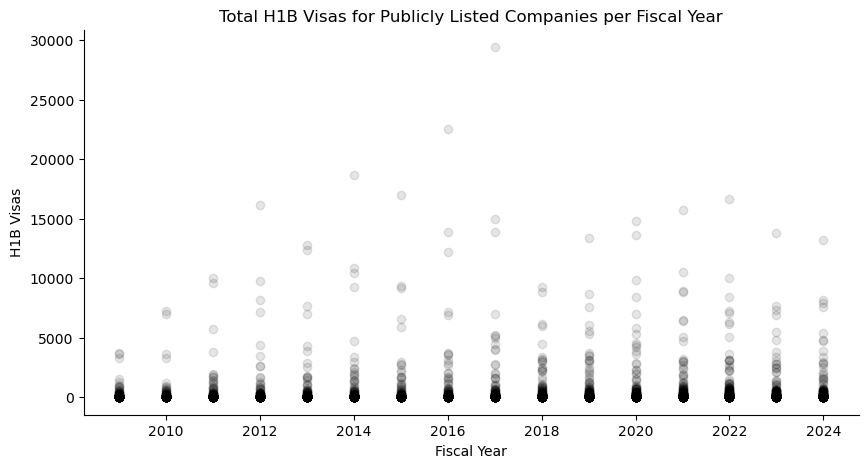

In [7]:
fig, ax = plt.subplots(figsize=(10,5)) 
ax.scatter('Fiscal Year', 'tot_app' ,data = h1b_df, color='black', alpha = .1)  

ax.set_ylabel('H1B Visas')
ax.set_xlabel('Fiscal Year')
ax.set_title('Total H1B Visas for Publicly Listed Companies per Fiscal Year')
sns.despine(ax=ax)

plt.show()

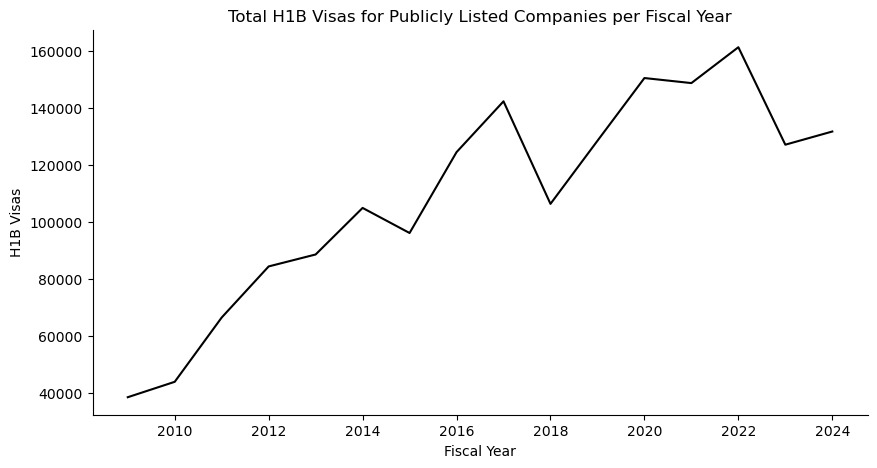

In [8]:
year_sums = h1b_df.groupby('Fiscal Year').sum().loc[:, ['tot_app']].reset_index()
fig, ax = plt.subplots(figsize=(10,5)) 

ax.plot('Fiscal Year', 'tot_app' ,data = year_sums, color='black')  
ax.set_ylabel('H1B Visas')
ax.set_xlabel('Fiscal Year')
ax.set_title('Total H1B Visas for Publicly Listed Companies per Fiscal Year')
sns.despine(ax=ax)

plt.show()


In [9]:
#Run once to have data locally
voo_data = yf.download('VOO', start="2008-01-01", end="2025-01-01", progress = False, interval='1wk')
#voo_data.to_csv('data/voo_hist_data.csv')
#voo_data = pd.read_csv('data/voo_hist_data.csv')
voo_data.head()

YF.download() has changed argument auto_adjust default to True


Price           Close       High        Low       Open  Volume
Ticker            VOO        VOO        VOO        VOO     VOO
Date                                                          
2010-09-06  77.804443  78.354839  77.315204  78.354839   35100
2010-09-13  79.012268  79.409773  78.263117  78.706492  211300
2010-09-20  80.143661  80.602329  78.828833  79.302781  113800
2010-09-27  80.486671  81.224516  79.487503  80.686506  142600
2010-10-04  81.993095  82.039209  79.548982  80.901700  496900

In [10]:
voo_data['year'] = voo_data.index.year
yearly_voo = voo_data.groupby('year').mean().droplevel('Ticker', axis=1)
yearly_voo.head()

Price       Close        High         Low        Open        Volume
year                                                               
2010    83.894030   84.346597   82.488780   83.438493  2.457647e+05
2011    90.351375   91.944939   88.499463   90.294929  1.089531e+06
2012   100.639403  101.689034   99.149783  100.294880  1.978665e+06
2013   123.059825  123.885119  121.346613  122.589882  4.896577e+06
2014   147.051351  148.269503  145.189702  146.769964  6.308038e+06

In [11]:
yearly_voo['vol_change'] = yearly_voo['Volume'].pct_change()
yearly_voo['open_change'] = yearly_voo['Open'].pct_change()
yearly_voo['close_change'] = yearly_voo['Close'].pct_change()
yearly_voo.head()

Price       Close        High         Low        Open        Volume  \
year                                                                  
2010    83.894030   84.346597   82.488780   83.438493  2.457647e+05   
2011    90.351375   91.944939   88.499463   90.294929  1.089531e+06   
2012   100.639403  101.689034   99.149783  100.294880  1.978665e+06   
2013   123.059825  123.885119  121.346613  122.589882  4.896577e+06   
2014   147.051351  148.269503  145.189702  146.769964  6.308038e+06   

Price  vol_change  open_change  close_change  
year                                          
2010          NaN          NaN           NaN  
2011     3.433227     0.082174      0.076970  
2012     0.816071     0.110748      0.113867  
2013     1.474687     0.222295      0.222780  
2014     0.288255     0.197244      0.194958

In [12]:
year_sums['chng'] = year_sums['tot_app'].pct_change()
year_sums.head(2)

Fiscal Year  tot_app      chng
0         2009    38448      <NA>
1         2010    43857  0.140684

In [13]:
combined = yearly_voo.merge(year_sums, left_on='year', right_on='Fiscal Year')
combined.head(2)

Close       High        Low       Open        Volume  vol_change  \
0  83.894030  84.346597  82.488780  83.438493  2.457647e+05         NaN   
1  90.351375  91.944939  88.499463  90.294929  1.089531e+06    3.433227   

   open_change  close_change  Fiscal Year  tot_app      chng  
0          NaN           NaN         2010    43857  0.140684  
1     0.082174       0.07697         2011    66420  0.514467

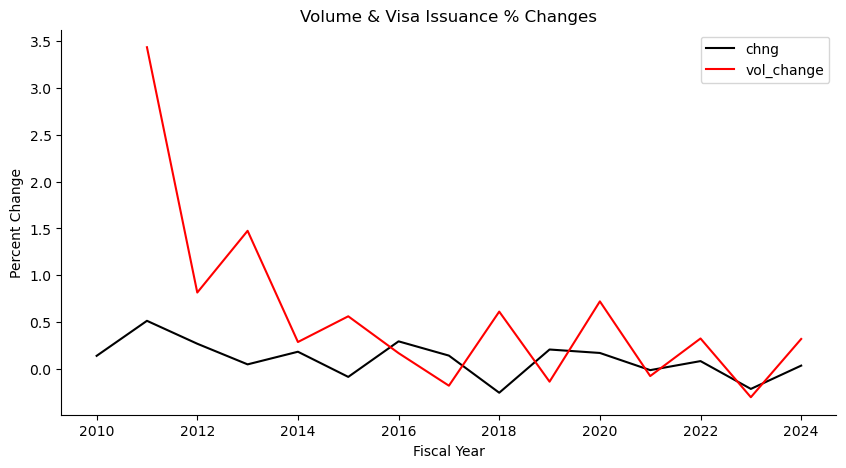

In [14]:

fig, ax = plt.subplots(figsize=(10,5)) 

ax.plot('Fiscal Year', 'chng' ,data = combined, color='black')  
ax.plot('Fiscal Year', 'vol_change' ,data = combined, color='red') 
ax.set_ylabel('Percent Change')
ax.set_xlabel('Fiscal Year')
ax.set_title('Volume & Visa Issuance % Changes')
ax.legend()
sns.despine(ax=ax)

plt.show()

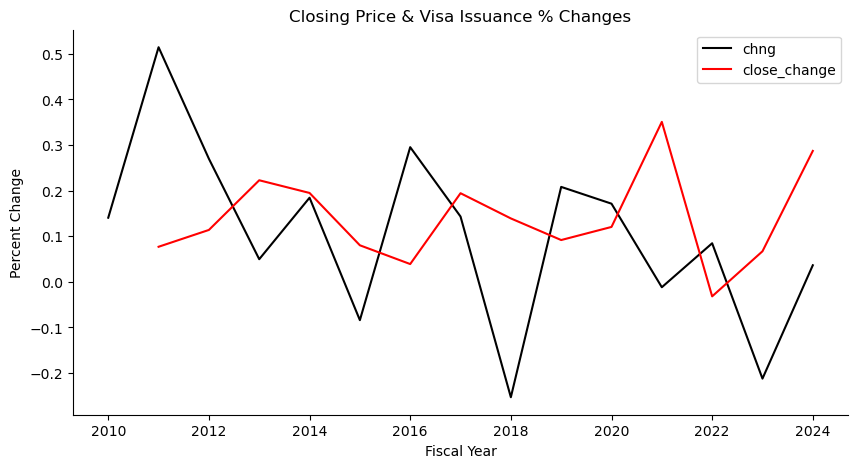

In [15]:

fig, ax = plt.subplots(figsize=(10,5)) 

ax.plot('Fiscal Year', 'chng' ,data = combined, color='black')  
ax.plot('Fiscal Year', 'close_change' ,data = combined, color='red') 
ax.set_ylabel('Percent Change')
ax.set_xlabel('Fiscal Year')
ax.set_title('Closing Price & Visa Issuance % Changes')
ax.legend()
sns.despine(ax=ax)

plt.show()

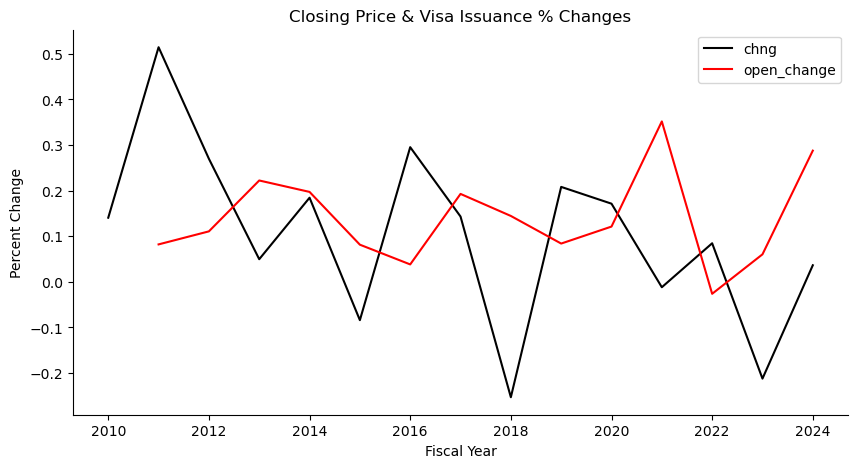

In [16]:

fig, ax = plt.subplots(figsize=(10,5)) 

ax.plot('Fiscal Year', 'chng' ,data = combined, color='black')  
ax.plot('Fiscal Year', 'open_change' ,data = combined, color='red') 
ax.set_ylabel('Percent Change')
ax.set_xlabel('Fiscal Year')
ax.set_title('Closing Price & Visa Issuance % Changes')
ax.legend()
sns.despine(ax=ax)

plt.show()

In [17]:
import time
def fetch_stock_info(tickers):
    #all_data = {}
    infor = {}
    dict_list = []
    print('Downloading yfinance information on select tickers...')
    for ticker in tickers:
        try:
            infor[ticker] = yf.Ticker(ticker).info
            time.sleep(2.001)  # Sleep for 2 seconds between requests to avoid being blocked

        except Exception as e:
            print(f"Error downloading {ticker}: {e}")
            time.sleep(2.001)
    return pd.DataFrame(infor)

In [18]:
company_info_df = fetch_stock_info(h1b_df['ticker'].unique())
company_info_df.to_csv('company_info_df.csv')

Error downloading BCOV: list index out of range
Error downloading BKDT: list index out of range
Error downloading CUTR: list index out of range
Error downloading EDR: list index out of range


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/EVGRW?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=EVGRW&crumb=DNrvc04GJXF


Error downloading EVGRW: 'NoneType' object has no attribute 'update'
Error downloading INFN: list index out of range


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/LAWR?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=LAWR&crumb=DNrvc04GJXF


Error downloading LAWR: 'NoneType' object has no attribute 'update'
Error downloading PEV: list index out of range
Error downloading PFC: list index out of range
Error downloading SLGB: list index out of range
Error downloading SNDKV: list index out of range
Error downloading TCS: list index out of range


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TECHM?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TECHM&crumb=DNrvc04GJXF


Error downloading TECHM: 'NoneType' object has no attribute 'update'
Error downloading WDCVV: list index out of range
Error downloading CCLDP: list index out of range
Error downloading EMKR: list index out of range
Error downloading IVAC: list index out of range
Error downloading SQ: list index out of range
Error downloading SWI: list index out of range


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CTV?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CTV&crumb=DNrvc04GJXF


Error downloading CTV: 'NoneType' object has no attribute 'update'
Error downloading ITCI: list index out of range
Error downloading TMGX: list index out of range


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ZUO?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ZUO&crumb=DNrvc04GJXF


Error downloading ZUO: 'NoneType' object has no attribute 'update'
Error downloading SONGD: list index out of range
Error downloading EVOY: list index out of range
Error downloading VOXX: list index out of range
Error downloading BEST: list index out of range
Error downloading ACCD: list index out of range
Error downloading CDMO: list index out of range
Error downloading ICCH: list index out of range
Error downloading DM: list index out of range
Error downloading EMPG: list index out of range
Error downloading HCP: list index out of range
Error downloading OMIC: list index out of range
Error downloading NKLA: list index out of range
Error downloading NVRO: list index out of range
Error downloading ALVR: list index out of range
Error downloading AURS: list index out of range
Error downloading BHILW: list index out of range
Error downloading OMGA: list index out of range
Error downloading DNMRW: list index out of range
Error downloading KNWN: list index out of range
Error downloading AIM

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NARI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NARI&crumb=DNrvc04GJXF


Error downloading NARI: 'NoneType' object has no attribute 'update'
Error downloading NXU: list index out of range
Error downloading ZOM: list index out of range
Error downloading ATSG: list index out of range


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/FTAIO?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=FTAIO&crumb=DNrvc04GJXF


Error downloading FTAIO: 'NoneType' object has no attribute 'update'
Error downloading ODTX: list index out of range


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SUM?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SUM&crumb=DNrvc04GJXF


Error downloading SUM: 'NoneType' object has no attribute 'update'
Error downloading TTTPF: list index out of range


In [19]:
company_info_df = pd.read_csv('company_info_df.csv').T
company_info_df = company_info_df.rename(columns=company_info_df.iloc[0]).drop(company_info_df.index[0])
company_info_df.head()

address1         city state         zip  \
A     5301 Stevens Creek Boulevard  Santa Clara    CA       95051   
AA             201 Isabella Street   Pittsburgh    PA  15212-5858   
AAL                1 Skyview Drive   Fort Worth    TX       76155   
AAMI          200 Clarendon Street       Boston    MA       02116   
AAOI   13139 Jess Pirtle Boulevard   Sugar Land    TX       77478   

            country           phone           fax                  website  \
A     United States    800 227 9770  866 497 1134  https://www.agilent.com   
AA    United States    412 315 2900           NaN    https://www.alcoa.com   
AAL   United States    682 278 9000           NaN       https://www.aa.com   
AAMI  United States    617-369-7300           NaN     https://www.bsig.com   
AAOI  United States  (281) 295-1800           NaN   https://www.ao-inc.com   

                     industry              industryKey  ... fundFamily  \
A      Diagnostics & Research     diagnostics-research  ...        NaN   
AA                   Aluminum                 aluminum  ...        NaN   
AAL                  Airlines                 airlines  ...        NaN   
AAMI         Asset Management         asset-management  ...        NaN   
AAOI  Communication Equipment  communication-equipment  ...        NaN   

     fundInceptionDate legalType threeYearAverageReturn  \
A                  NaN       NaN                    NaN   
AA                 NaN       NaN                    NaN   
AAL                NaN       NaN                    NaN   
AAMI               NaN       NaN                    NaN   
AAOI               NaN       NaN                    NaN   

     trailingThreeMonthReturns trailingThreeMonthNavReturns netAssets  \
A                          NaN                          NaN       NaN   
AA                         NaN                          NaN       NaN   
AAL                        NaN                          NaN       NaN   
AAMI                       NaN                          NaN       NaN   
AAOI                       NaN                          NaN       NaN   

     netExpenseRatio fiveYearAverageReturn newSymbol  
A                NaN                   NaN       NaN  
AA               NaN                   NaN       NaN  
AAL              NaN                   NaN       NaN  
AAMI             NaN                   NaN       NaN  
AAOI             NaN                   NaN       NaN  

[5 rows x 198 columns]

In [20]:
drop_cols_2 = []
for x in company_info_df.columns:
    if x in ["sector", "auditRisk", "boardRisk", "overallRisk", "totalAssets"]:
        continue
    if len(company_info_df[x].unique()) < 20:
        drop_cols_2.append(x)

print(drop_cols_2) 

['sectorKey', 'sectorDisp', 'compensationRisk', 'shareHolderRightsRisk', 'governanceEpochDate', 'compensationAsOfEpochDate', 'executiveTeam', 'maxAge', 'priceHint', 'currency', 'tradeable', 'SandP52WeekChange', 'quoteType', 'recommendationKey', 'language', 'region', 'typeDisp', 'quoteSourceName', 'triggerable', 'customPriceAlertConfidence', 'exchange', 'exchangeTimezoneName', 'exchangeTimezoneShortName', 'gmtOffSetMilliseconds', 'market', 'esgPopulated', 'marketState', 'hasPrePostMarketData', 'isEarningsDateEstimate', 'sourceInterval', 'exchangeDataDelayedBy', 'fullExchangeName', 'cryptoTradeable', 'nameChangeDate', 'industrySymbol', 'yield', 'navPrice', 'category', 'ytdReturn', 'beta3Year', 'fundFamily', 'fundInceptionDate', 'legalType', 'threeYearAverageReturn', 'trailingThreeMonthReturns', 'trailingThreeMonthNavReturns', 'netAssets', 'netExpenseRatio', 'fiveYearAverageReturn', 'newSymbol']


In [21]:
company_info_df = company_info_df.drop(drop_cols_2, axis = 1)
company_info_df.head()

address1         city state         zip  \
A     5301 Stevens Creek Boulevard  Santa Clara    CA       95051   
AA             201 Isabella Street   Pittsburgh    PA  15212-5858   
AAL                1 Skyview Drive   Fort Worth    TX       76155   
AAMI          200 Clarendon Street       Boston    MA       02116   
AAOI   13139 Jess Pirtle Boulevard   Sugar Land    TX       77478   

            country           phone           fax                  website  \
A     United States    800 227 9770  866 497 1134  https://www.agilent.com   
AA    United States    412 315 2900           NaN    https://www.alcoa.com   
AAL   United States    682 278 9000           NaN       https://www.aa.com   
AAMI  United States    617-369-7300           NaN     https://www.bsig.com   
AAOI  United States  (281) 295-1800           NaN   https://www.ao-inc.com   

                     industry              industryKey  ...  \
A      Diagnostics & Research     diagnostics-research  ...   
AA                   Aluminum                 aluminum  ...   
AAL                  Airlines                 airlines  ...   
AAMI         Asset Management         asset-management  ...   
AAOI  Communication Equipment  communication-equipment  ...   

     averageAnalystRating firstTradeDateMilliseconds regularMarketChange  \
A               2.1 - Buy               942935400000          0.98000336   
AA              1.7 - Buy              -252322200000           1.1750011   
AAL             2.1 - Buy              1127827800000          0.16989994   
AAMI           3.0 - Hold              1412861400000          0.34000015   
AAOI            1.8 - Buy              1380202200000          0.70440006   

     regularMarketDayRange               displayName trailingPegRatio  \
A           103.16 - 106.0                   Agilent           1.7168   
AA           25.28 - 26.24                     Alcoa              NaN   
AAL            9.21 - 9.68         American Airlines           0.2903   
AAMI       26.2151 - 26.89  Acadian Asset Management              NaN   
AAOI        11.535 - 12.59   Applied Optoelectronics              NaN   

        address2                            prevName ipoExpectedDate  \
A            NaN                                 NaN             NaN   
AA     Suite 500                                 NaN             NaN   
AAL          NaN                                 NaN             NaN   
AAMI  53rd Floor  BrightSphere Investment Group Inc.             NaN   
AAOI         NaN                                 NaN             NaN   

     totalAssets  
A            NaN  
AA           NaN  
AAL          NaN  
AAMI         NaN  
AAOI         NaN  

[5 rows x 148 columns]

In [22]:
company_info_df.to_csv("company_info_df_clean.csv")


In [23]:
company_info_df = pd.read_csv("company_info_df_clean.csv")

In [24]:
h1b_2024 = h1b_df[h1b_df['Fiscal Year'] == 2024]
h1b_2024.head()

Fiscal Year ticker                 employer  Tax ID  \
18990         2024      A                  AGILENT    8772   
18991         2024     AA                    ALCOA    9115   
18992         2024    AAL        AMERICAN AIRLINES    2798   
18993         2024   AAMI            ACADIAN ASSET    9221   
18994         2024   AAOI  APPLIED OPTOELECTRONICS    3927   

                        Industry (NAICS) Code Petitioner City  \
18990                   31-33 - Manufacturing     SANTA CLARA   
18991                   31-33 - Manufacturing      PITTSBURGH   
18992  48-49 - Transportation and Warehousing      FORT WORTH   
18993              52 - Finance and Insurance          BOSTON   
18994                   31-33 - Manufacturing      SUGAR LAND   

      Petitioner State  Petitioner Zip Code  Initial Approval  \
18990               CA                95052                11   
18991               PA                15212                 1   
18992               TX                76155                43   
18993               MA                 2110                 4   
18994               TX                77478                 4   

       Continuing Approval type  tot_app  
18990                   24  h1b       35  
18991                    2  h1b        3  
18992                  228  h1b      271  
18993                    4  h1b        8  
18994                    6  h1b       10

In [25]:
visa_and_info_df = company_info_df.merge(h1b_2024, how = 'inner', left_on='symbol', right_on='ticker')
visa_and_info_df.head()

Unnamed: 0                      address1         city state         zip  \
0          A  5301 Stevens Creek Boulevard  Santa Clara    CA       95051   
1         AA           201 Isabella Street   Pittsburgh    PA  15212-5858   
2        AAL               1 Skyview Drive   Fort Worth    TX       76155   
3       AAMI          200 Clarendon Street       Boston    MA       02116   
4       AAOI   13139 Jess Pirtle Boulevard   Sugar Land    TX       77478   

         country           phone           fax                  website  \
0  United States    800 227 9770  866 497 1134  https://www.agilent.com   
1  United States    412 315 2900           NaN    https://www.alcoa.com   
2  United States    682 278 9000           NaN       https://www.aa.com   
3  United States    617-369-7300           NaN     https://www.bsig.com   
4  United States  (281) 295-1800           NaN   https://www.ao-inc.com   

                  industry  ...                 employer Tax ID  \
0   Diagnostics & Research  ...                  AGILENT   8772   
1                 Aluminum  ...                    ALCOA   9115   
2                 Airlines  ...        AMERICAN AIRLINES   2798   
3         Asset Management  ...            ACADIAN ASSET   9221   
4  Communication Equipment  ...  APPLIED OPTOELECTRONICS   3927   

                    Industry (NAICS) Code Petitioner City  Petitioner State  \
0                   31-33 - Manufacturing     SANTA CLARA                CA   
1                   31-33 - Manufacturing      PITTSBURGH                PA   
2  48-49 - Transportation and Warehousing      FORT WORTH                TX   
3              52 - Finance and Insurance          BOSTON                MA   
4                   31-33 - Manufacturing      SUGAR LAND                TX   

  Petitioner Zip Code  Initial Approval  Continuing Approval  type tot_app  
0               95052                11                   24   h1b      35  
1               15212                 1                    2   h1b       3  
2               76155                43                  228   h1b     271  
3                2110                 4                    4   h1b       8  
4               77478                 4                    6   h1b      10  

[5 rows x 161 columns]

In [26]:
visa_and_info_df.groupby('industry').sum()['tot_app']

industry
Advertising Agencies              116
Aerospace & Defense               201
Agricultural Inputs                27
Airlines                          499
Aluminum                            5
                                 ... 
Utilities - Regulated Electric    103
Utilities - Regulated Gas          27
Utilities - Regulated Water         3
Utilities - Renewable              58
Waste Management                   36
Name: tot_app, Length: 132, dtype: Int64

In [27]:
visa_and_info_df.groupby('sector').sum()['tot_app']

sector
Basic Materials             485
Communication Services    13476
Consumer Cyclical         20994
Consumer Defensive         4057
Energy                      274
Financial Services         7998
Healthcare                 5944
Industrials                4993
Real Estate                 444
Technology                58882
Utilities                   235
Name: tot_app, dtype: Int64

In [28]:
visa_and_info_df.groupby('city').sum()['tot_app']

city
Acton             34
Addison            1
Admiralty          6
Alachua            1
Alameda           52
                  ..
Woodcliff Lake     2
Woodland Hills    20
Worcester          6
Zeeland            6
Zurich            48
Name: tot_app, Length: 553, dtype: Int64

In [29]:
visa_and_info_df.groupby('state').sum()['tot_app']

state
AB        80
AL         8
AR      3429
AZ       642
BC        34
CA     37707
CO       363
CT       623
DC        89
DE        40
FL      1045
GA      1124
IA        41
ID       374
IL      1424
IN      1497
KS         4
KY       250
LA        33
MA      1981
MD       228
ME        11
MG         2
MI      1622
MN       410
MO       236
MS         2
MT       307
NC      1581
NE        42
NF         1
NH        21
NJ      8392
NM         4
NSW      166
NV        86
NY      8599
OH       566
OK        19
ON       187
OR       328
PA       838
QC        25
RI         2
SC        27
SP        18
TN       363
TX      4183
UT       160
VA      1010
WA     19259
WI       558
WV         2
Name: tot_app, dtype: Int64

In [30]:
visa_and_info_df.groupby('zip').sum()['tot_app']

zip
01310-100    13
01532         8
01653         6
01701        14
01720        34
             ..
WA14 2DT      1
WC1A 1DG     13
WC2R 0RL      1
WD18 8YE     30
WIS 4PZ       2
Name: tot_app, Length: 993, dtype: Int64

In [31]:
visa_and_info_df.groupby('Industry (NAICS) Code').sum()['tot_app']

Industry (NAICS) Code
11 - Agriculture, Forestry, Fishing and Hunting                                      1
21 - Mining, Quarrying, and Oil and Gas Extraction                                 192
22 - Utilities                                                                     266
23 - Construction                                                                  181
31-33 - Manufacturing                                                            24282
42 - Wholesale Trade                                                               526
44-45 - Retail Trade                                                             19863
48-49 - Transportation and Warehousing                                             829
51 - Information                                                                 15771
52 - Finance and Insurance                                                        6390
53 - Real Estate and Rental and Leasing                                            400
54 - Professional, Sc

In [36]:
def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    return df

fullTimeEmployees


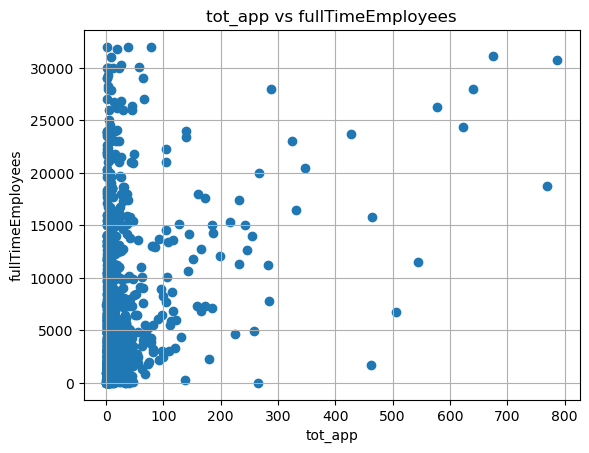

auditRisk


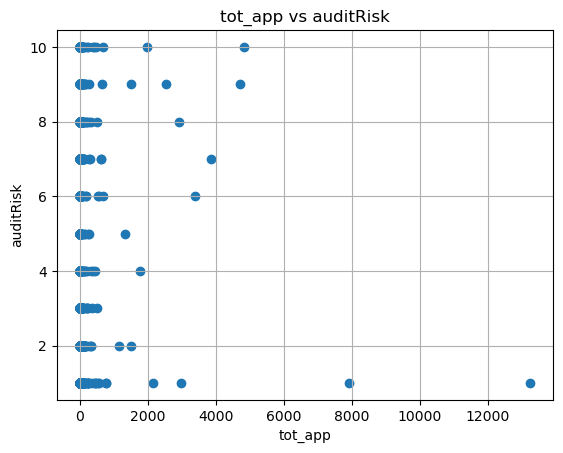

boardRisk


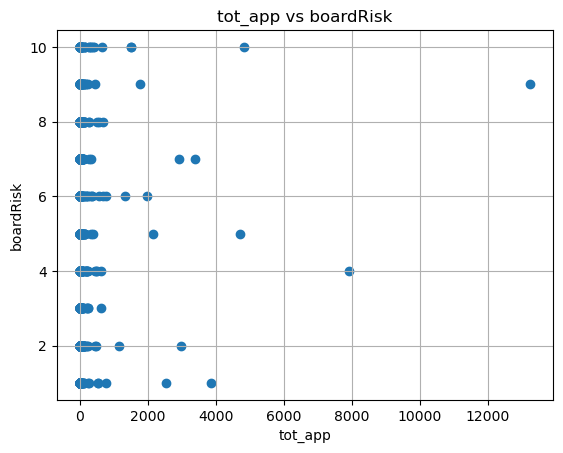

overallRisk


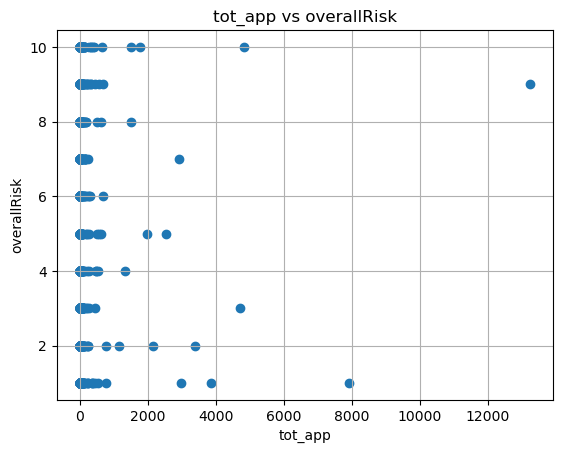

previousClose


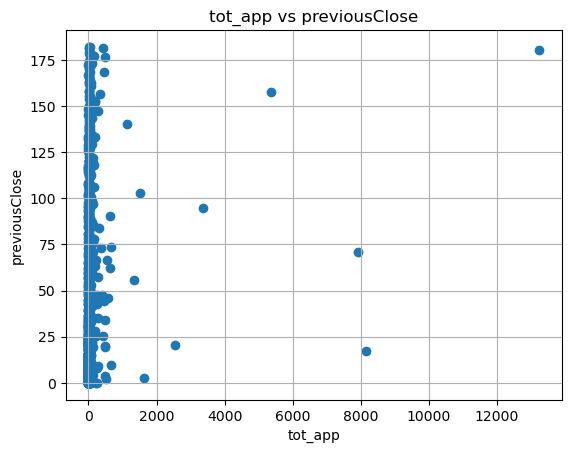

open


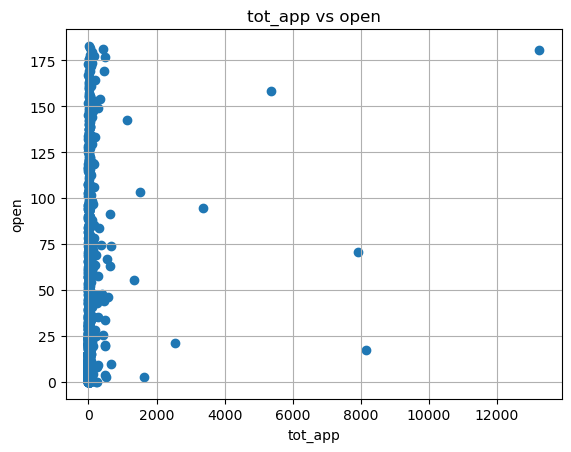

dayLow


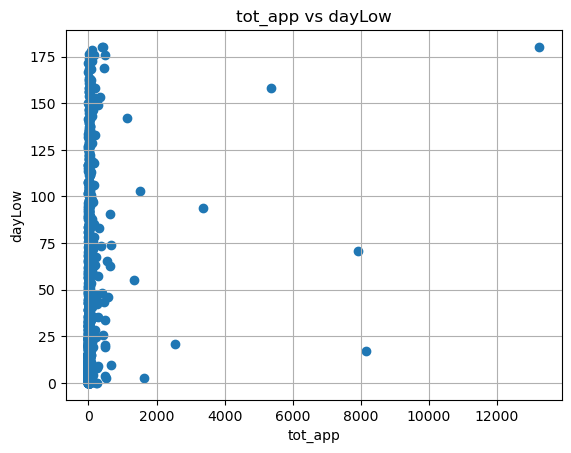

dayHigh


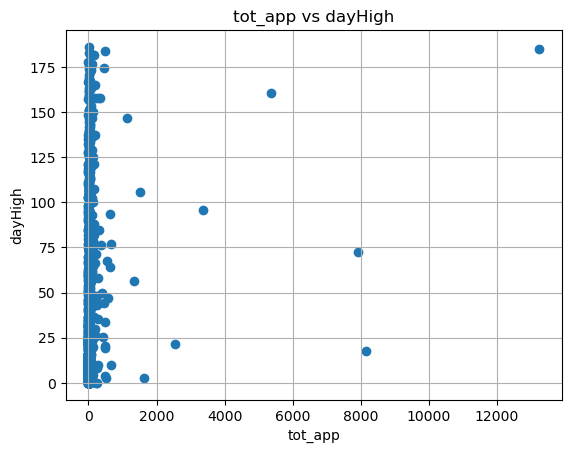

regularMarketPreviousClose


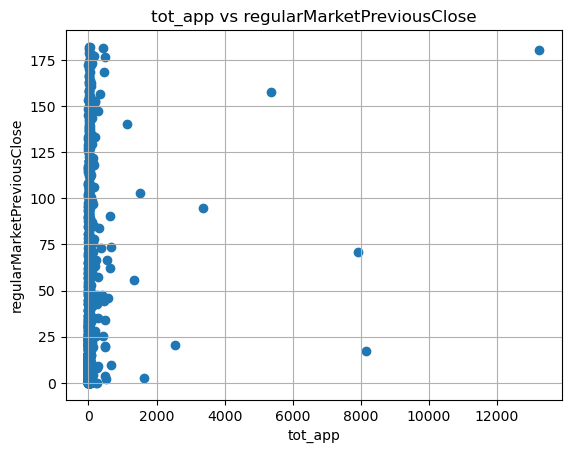

regularMarketOpen


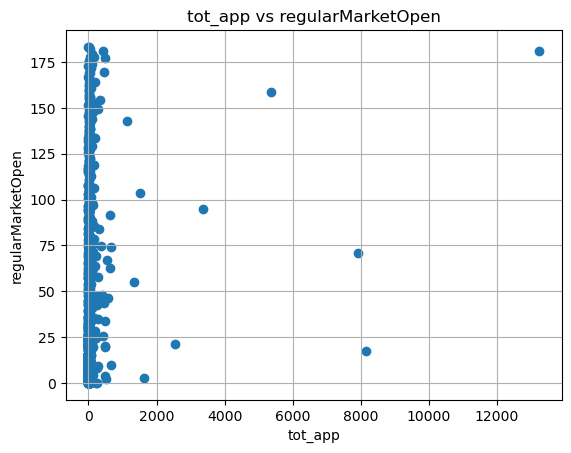

regularMarketDayLow


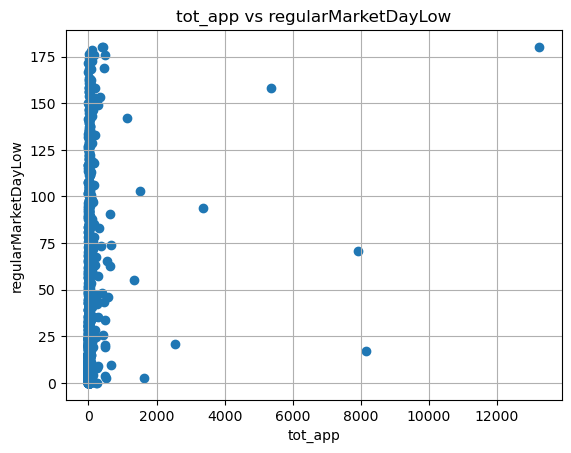

regularMarketDayHigh


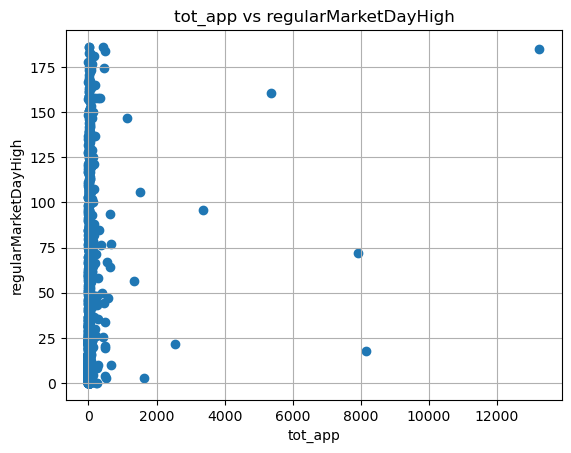

dividendRate


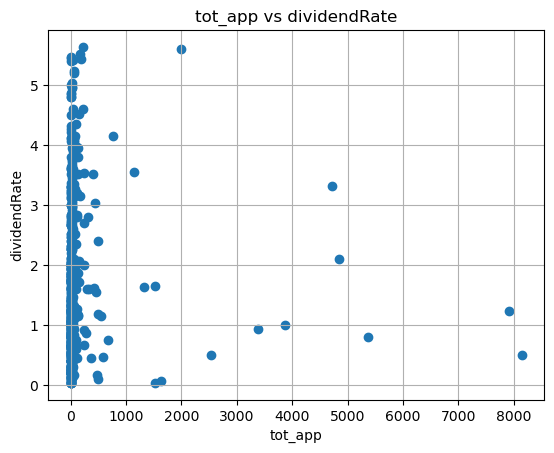

dividendYield


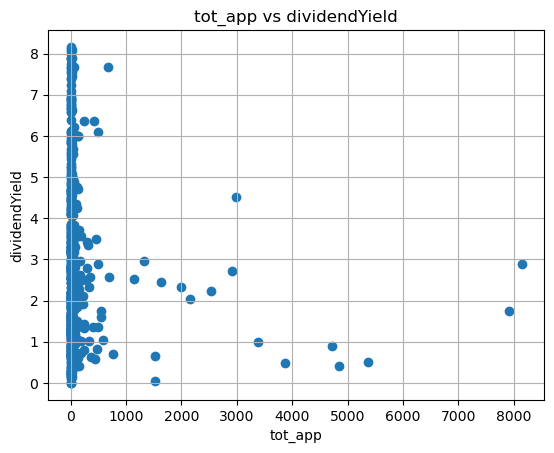

exDividendDate


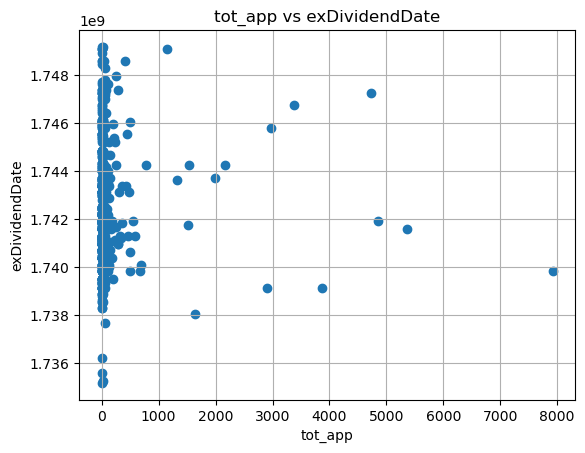

payoutRatio


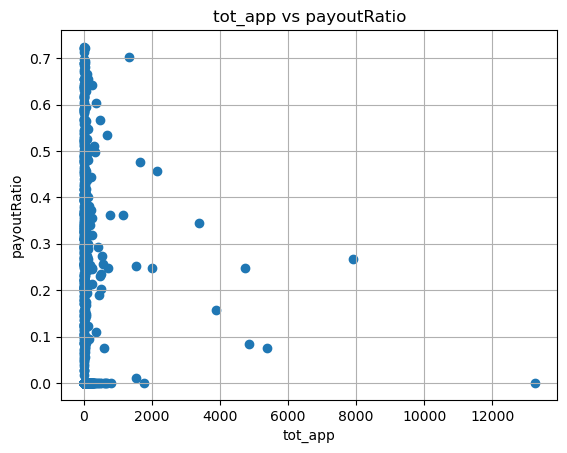

fiveYearAvgDividendYield


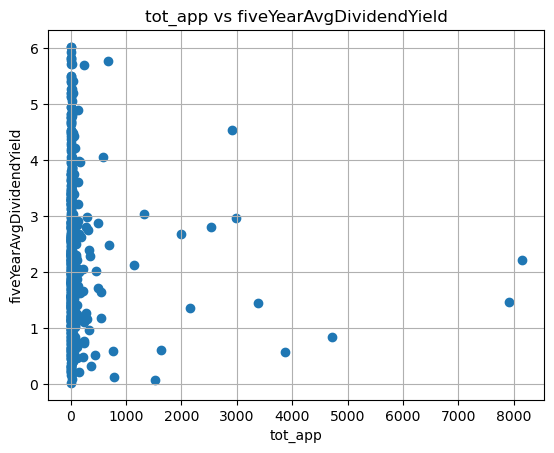

beta


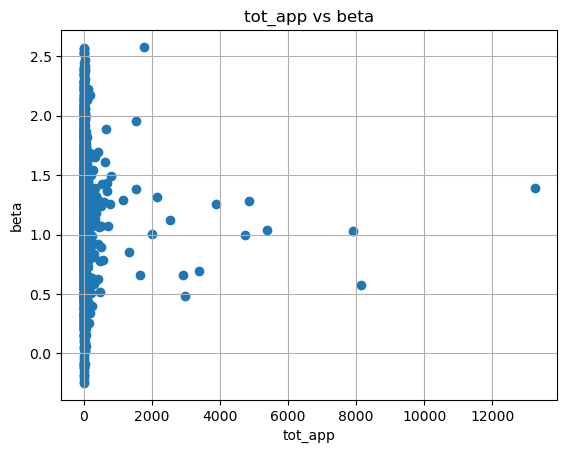

trailingPE


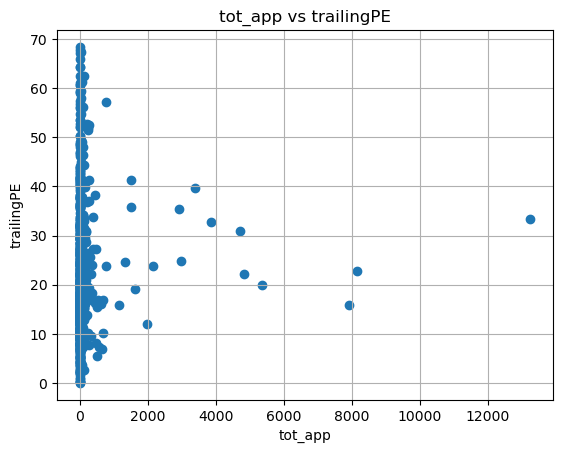

forwardPE


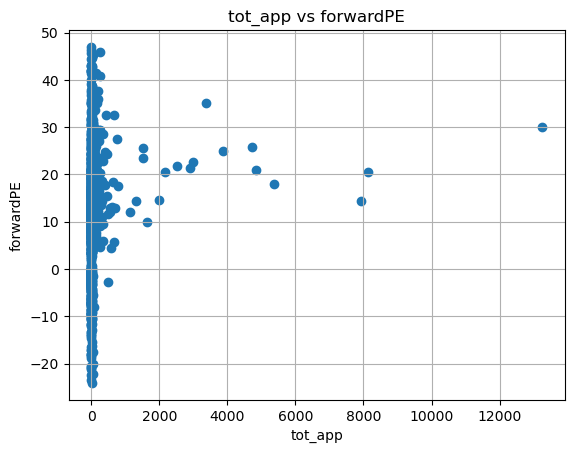

volume


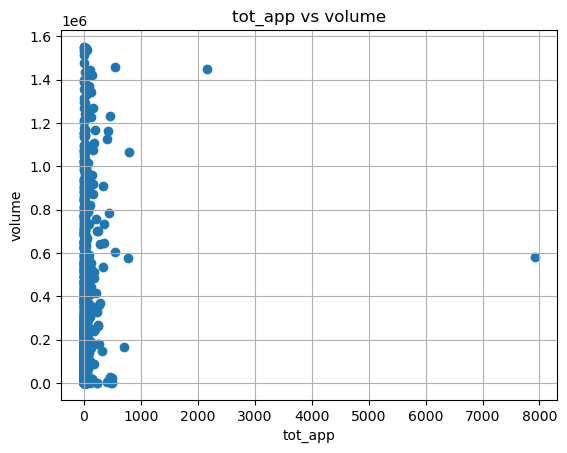

regularMarketVolume


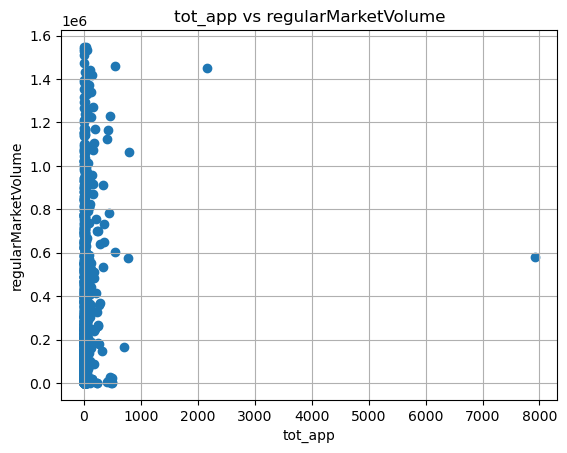

averageVolume


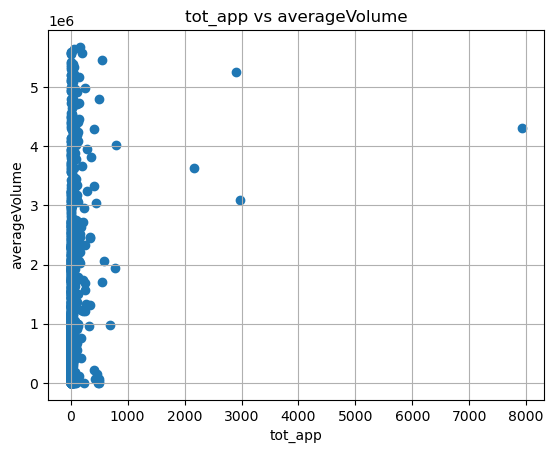

averageVolume10days


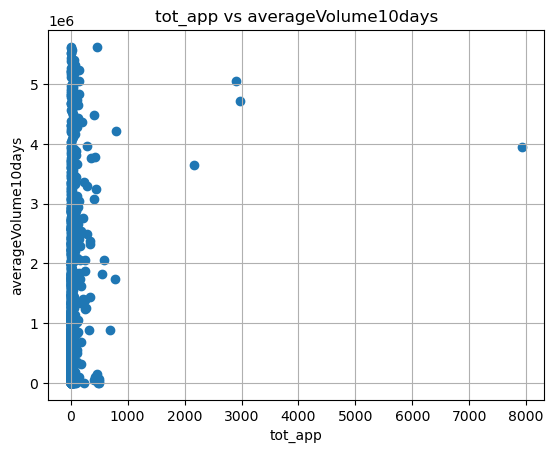

averageDailyVolume10Day


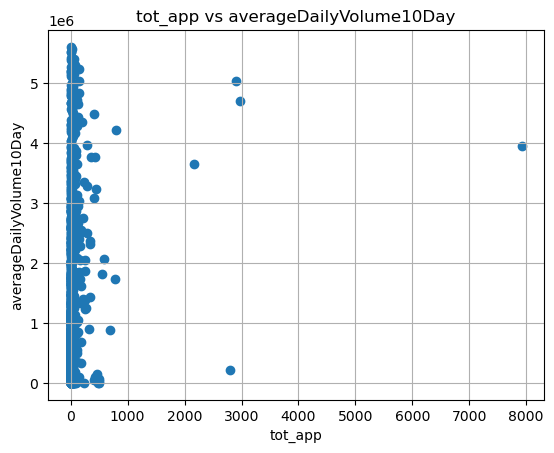

bid


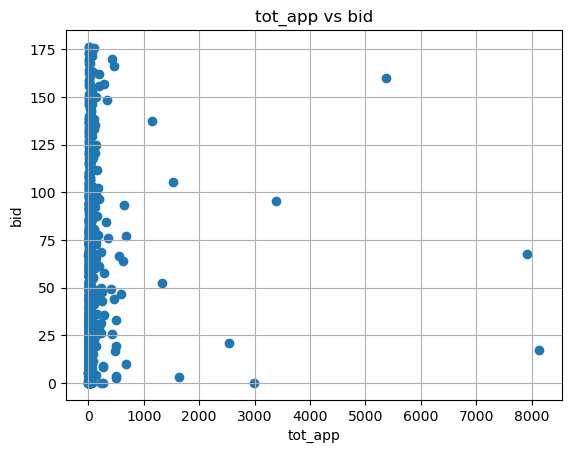

ask


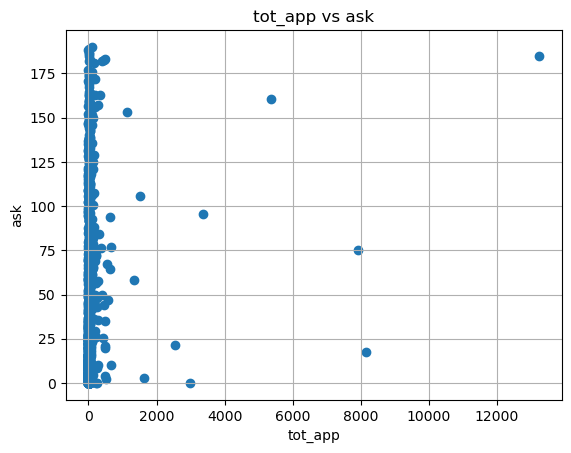

bidSize


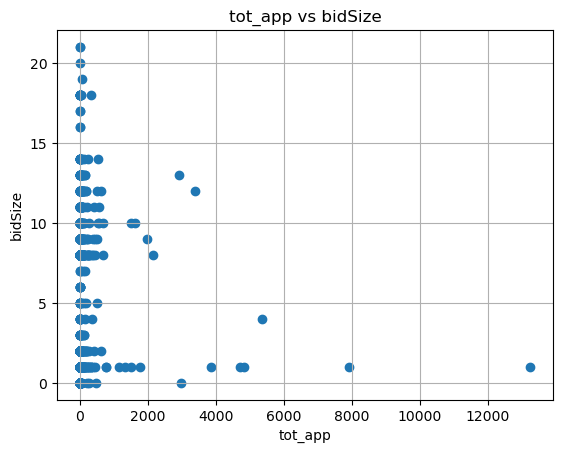

askSize


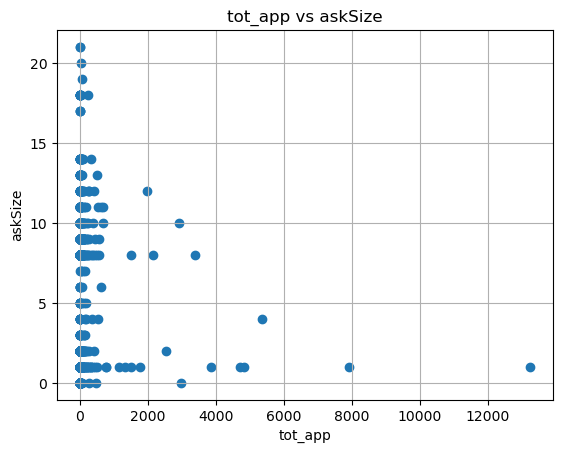

marketCap


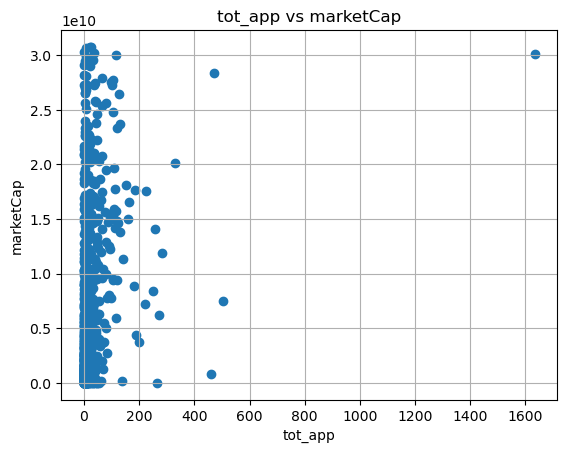

fiftyTwoWeekLow


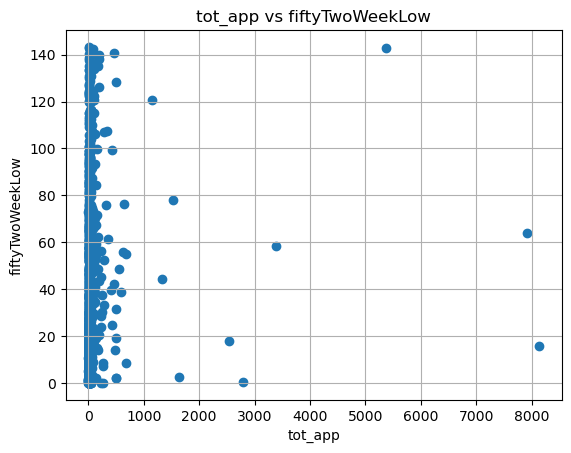

fiftyTwoWeekHigh


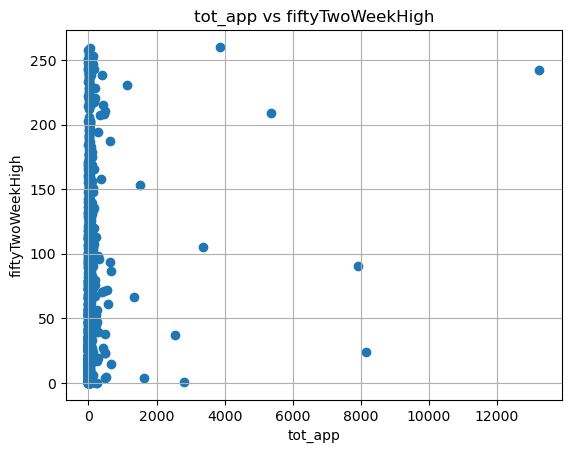

priceToSalesTrailing12Months


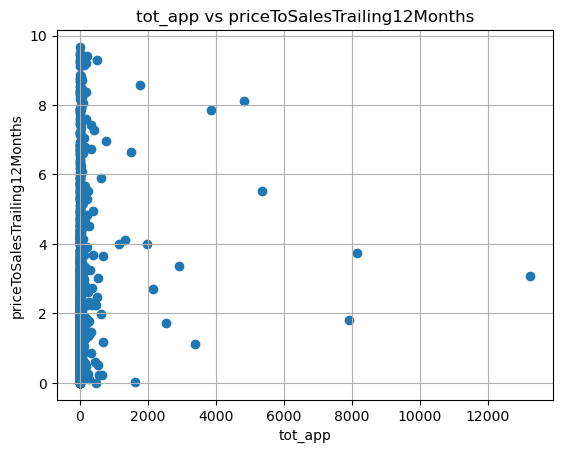

fiftyDayAverage


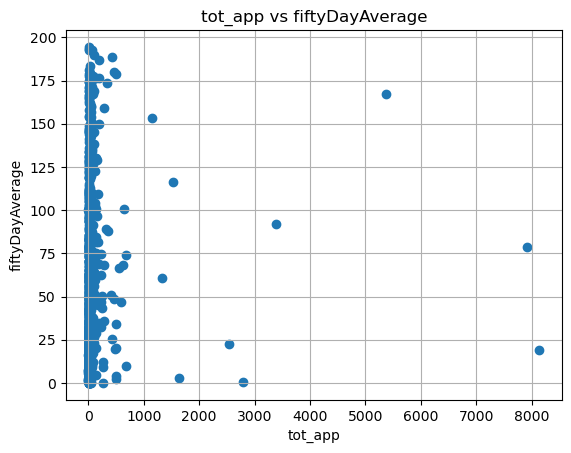

twoHundredDayAverage


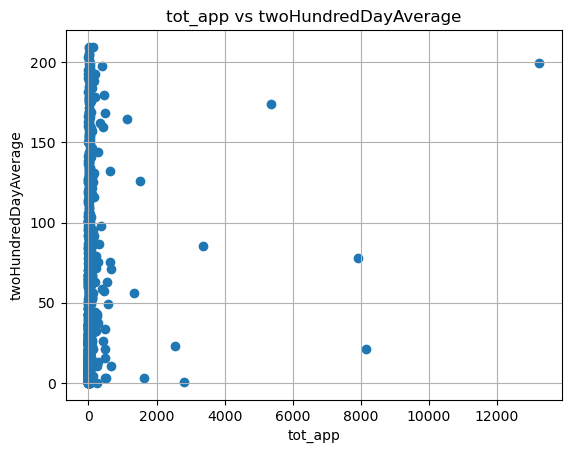

trailingAnnualDividendRate


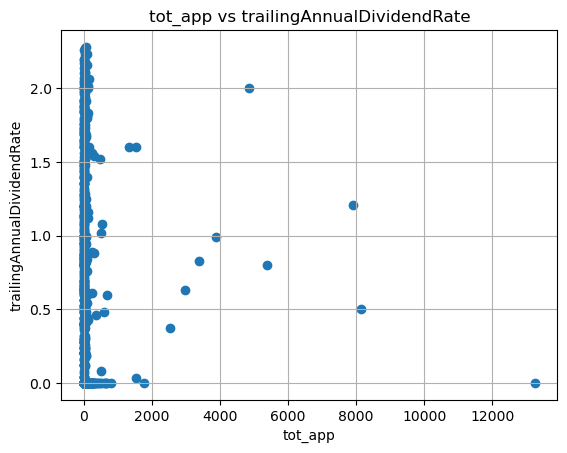

trailingAnnualDividendYield


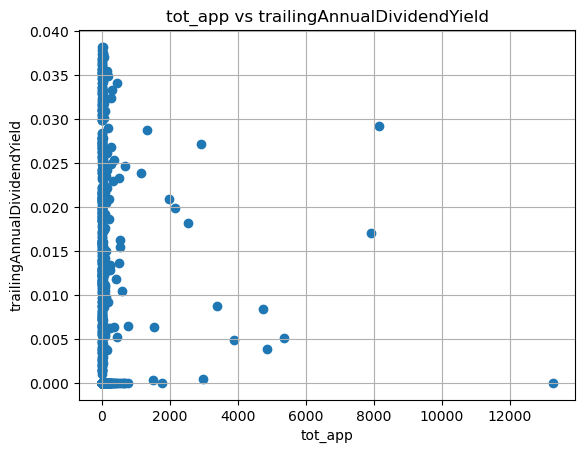

enterpriseValue


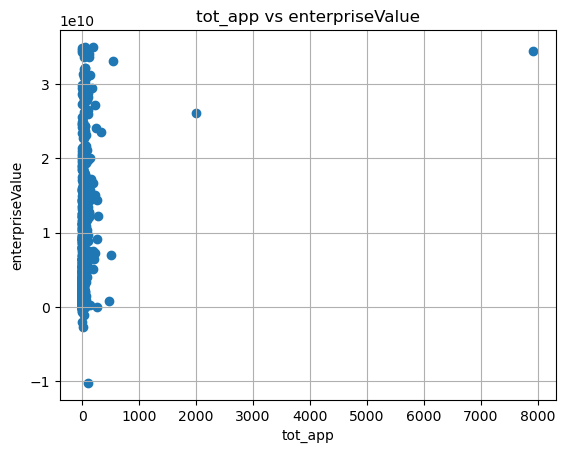

profitMargins


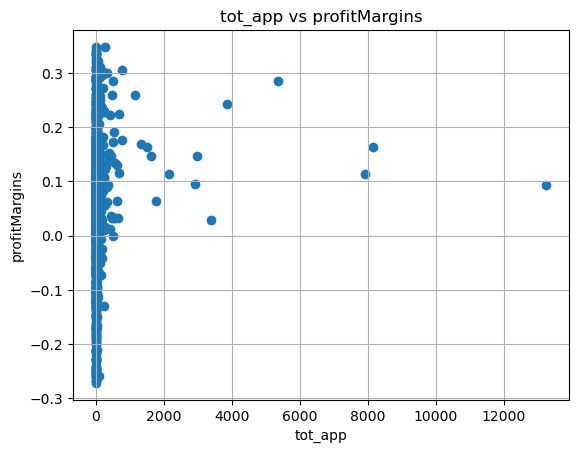

floatShares


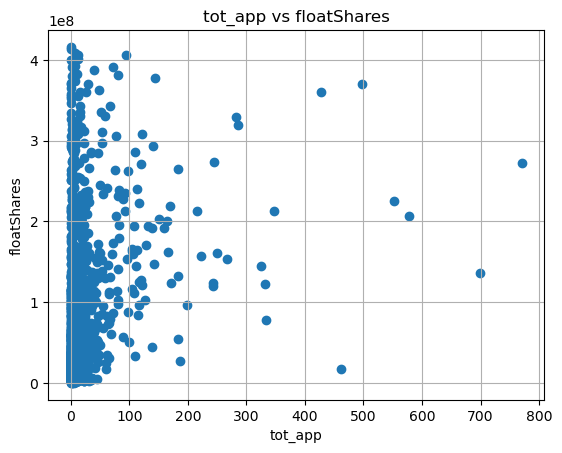

sharesOutstanding


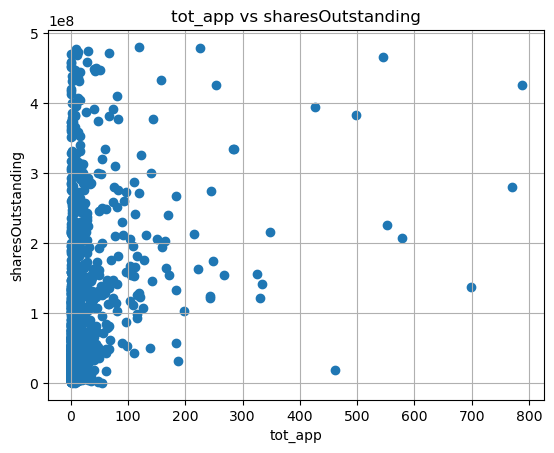

sharesShort


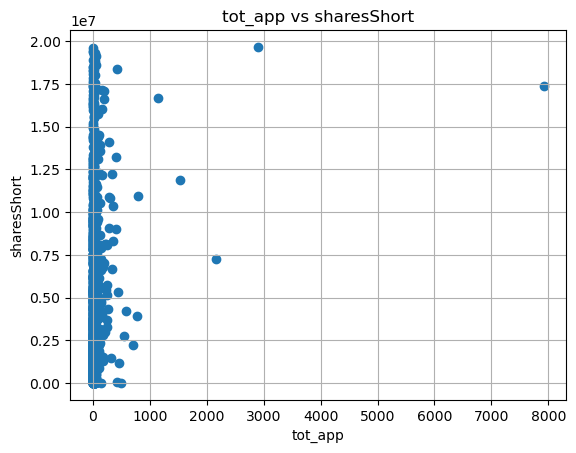

sharesShortPriorMonth


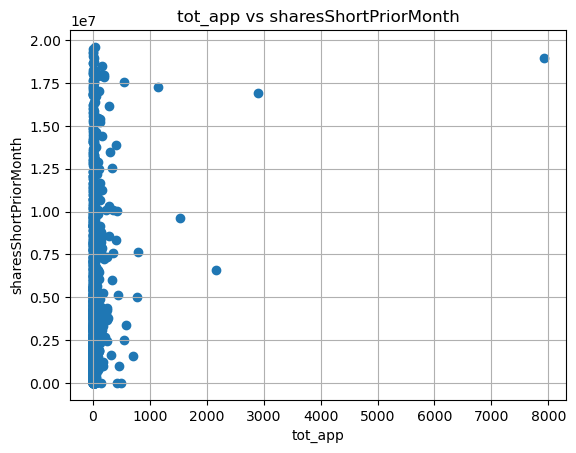

sharesShortPreviousMonthDate


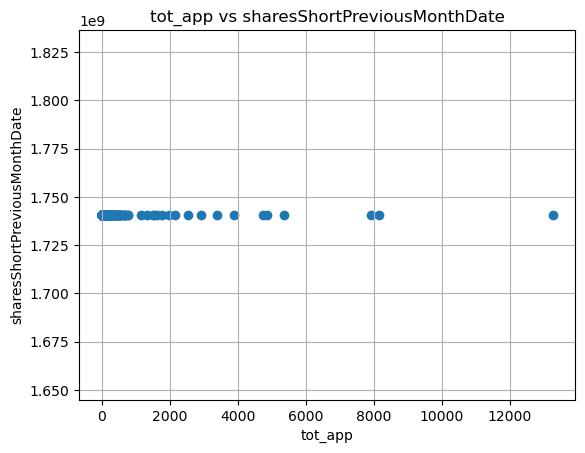

dateShortInterest


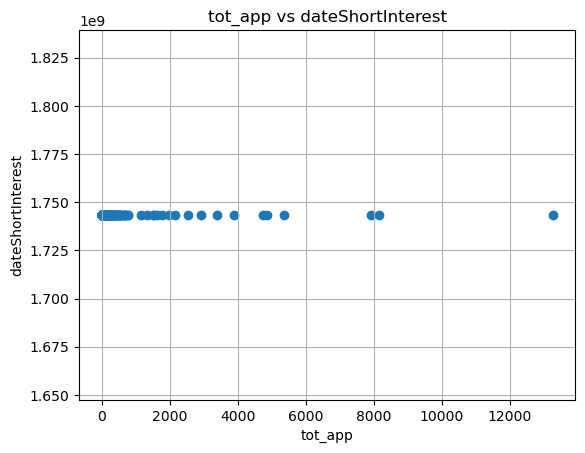

sharesPercentSharesOut


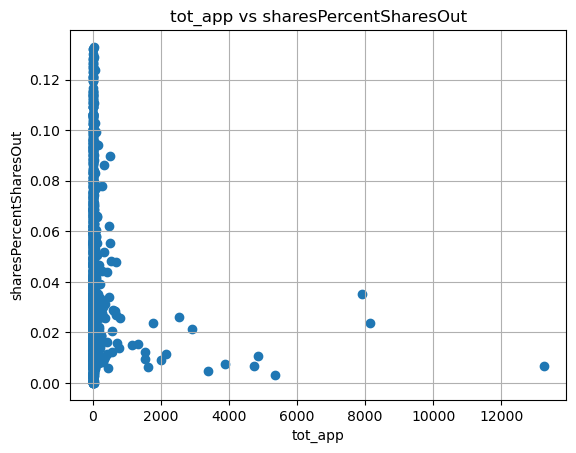

heldPercentInsiders


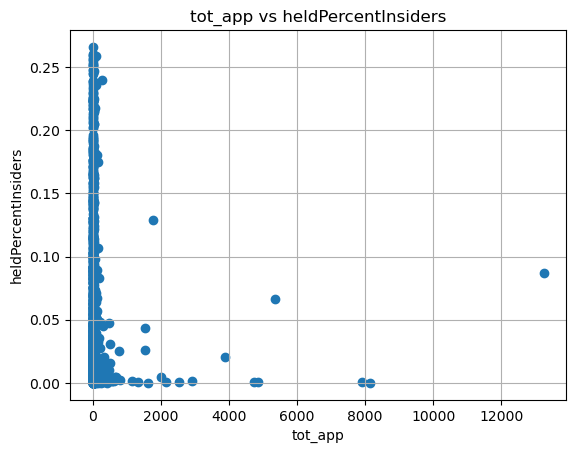

heldPercentInstitutions


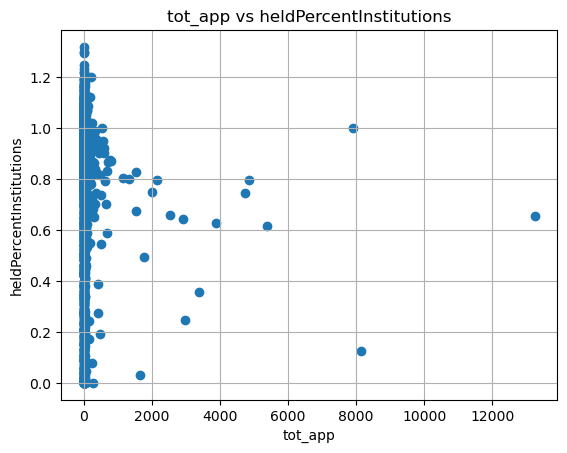

shortRatio


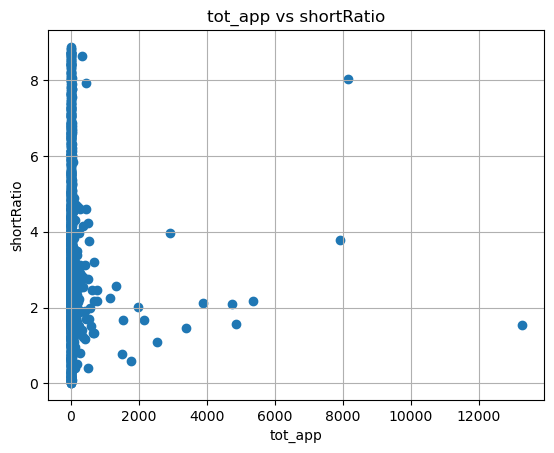

shortPercentOfFloat


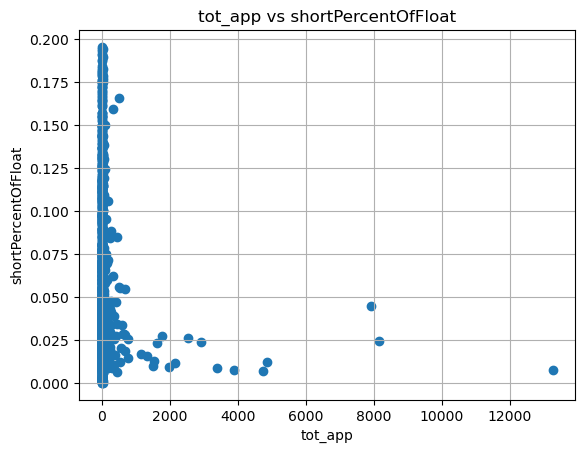

impliedSharesOutstanding


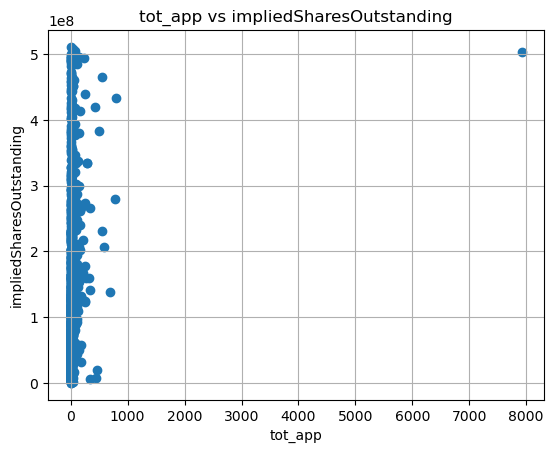

bookValue


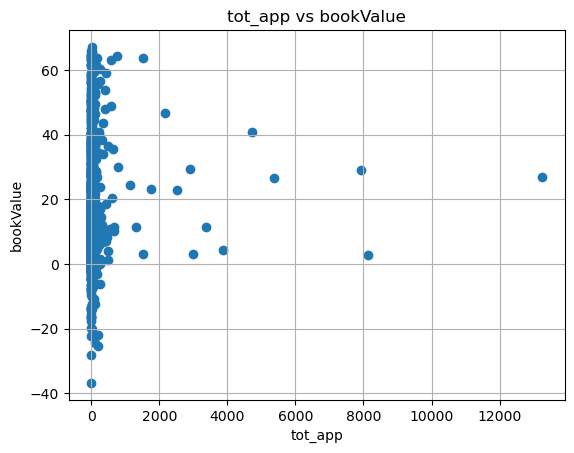

priceToBook


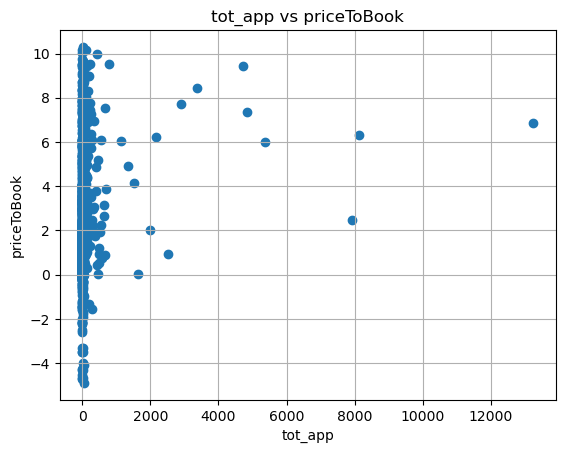

lastFiscalYearEnd


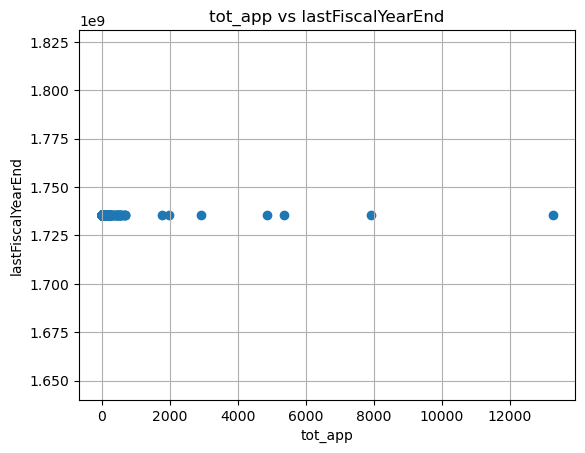

nextFiscalYearEnd


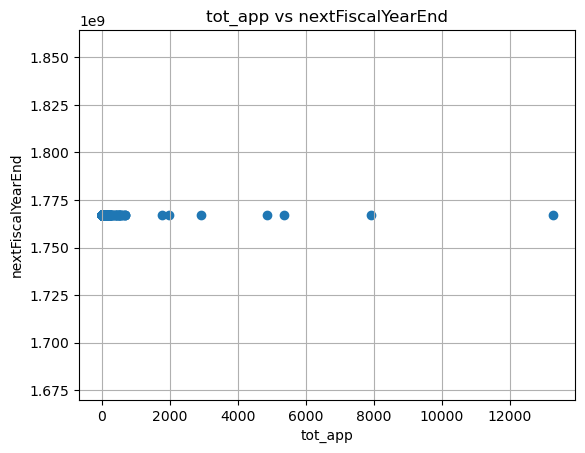

mostRecentQuarter


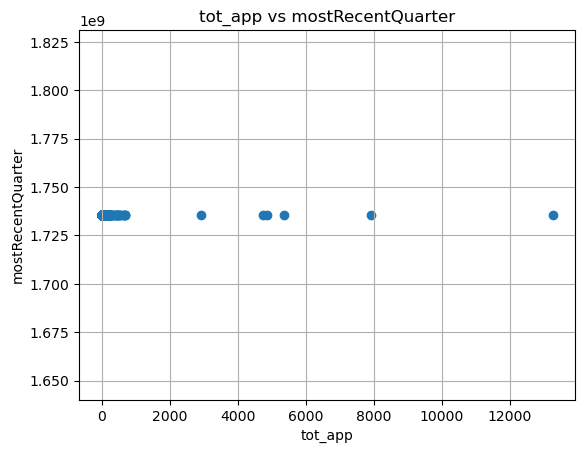

earningsQuarterlyGrowth


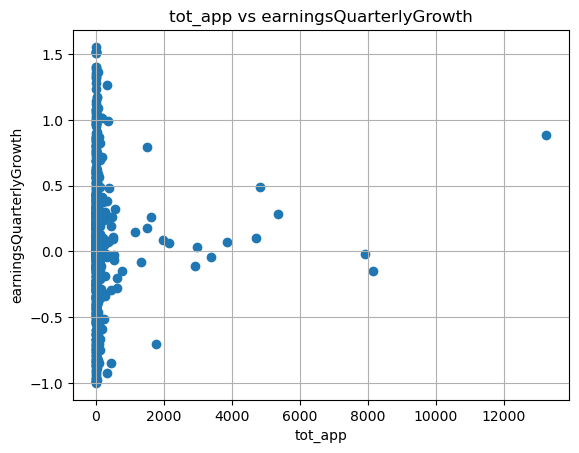

netIncomeToCommon


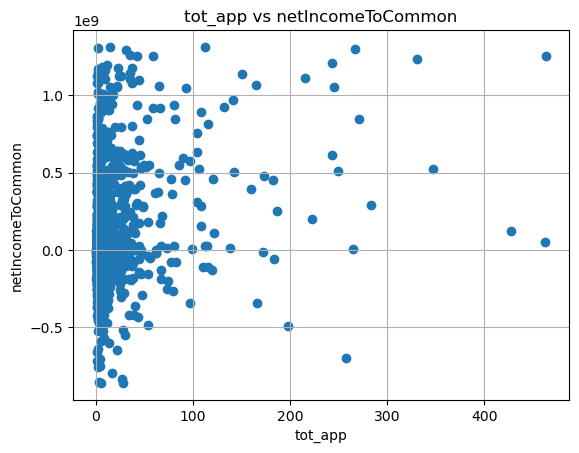

trailingEps


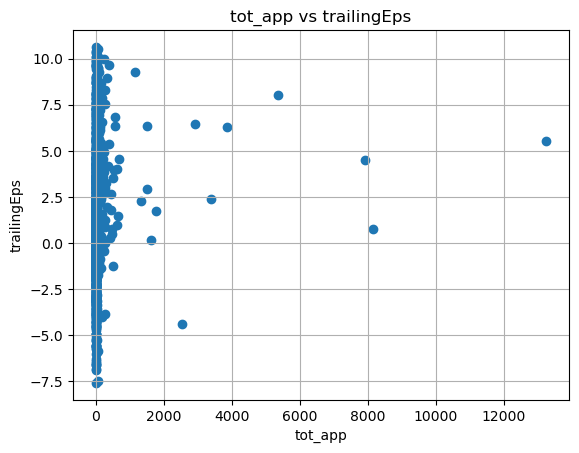

forwardEps


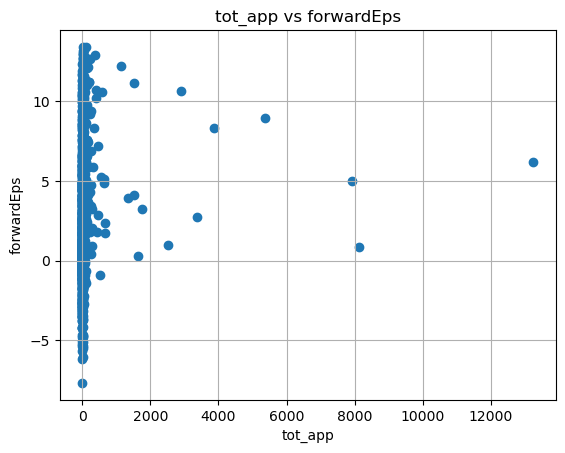

lastSplitDate


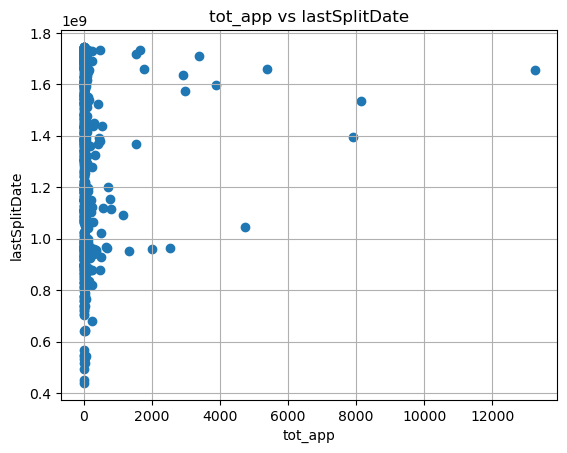

enterpriseToRevenue


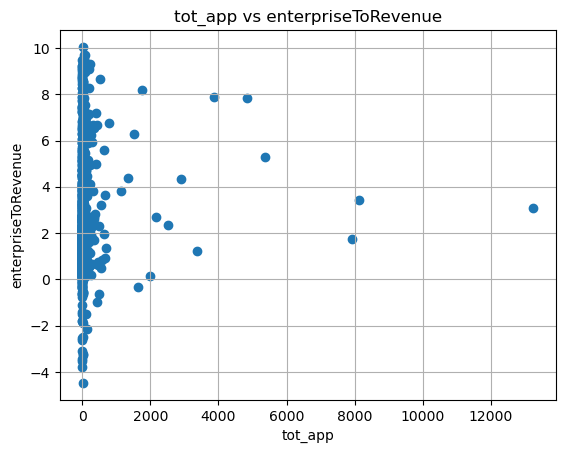

enterpriseToEbitda


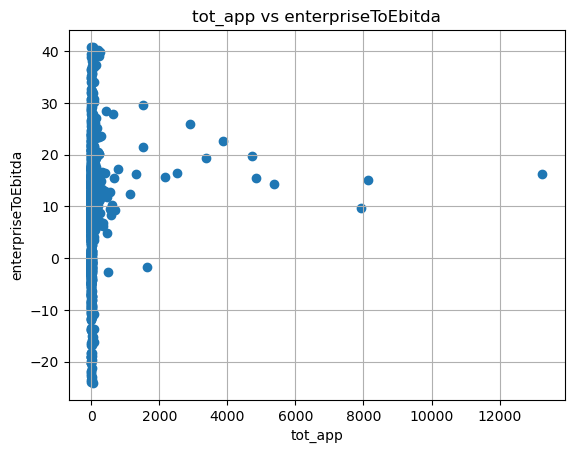

52WeekChange


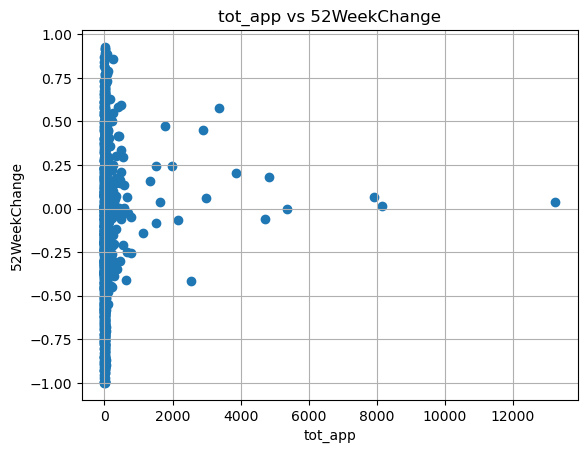

lastDividendValue


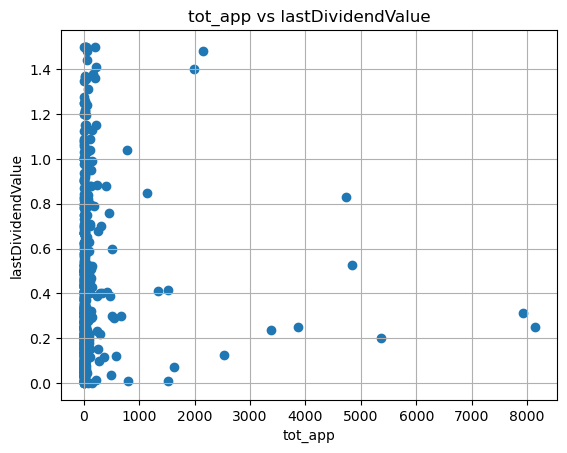

lastDividendDate


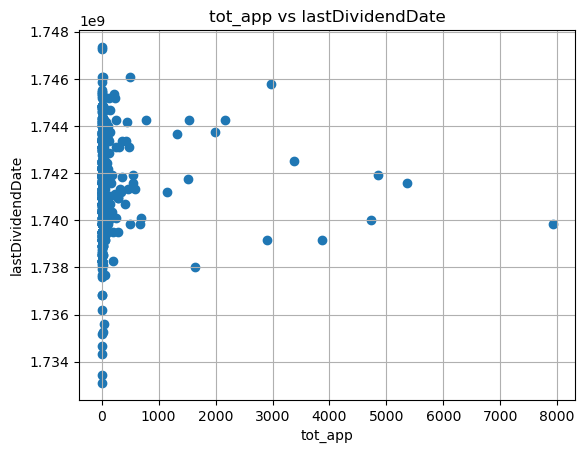

currentPrice


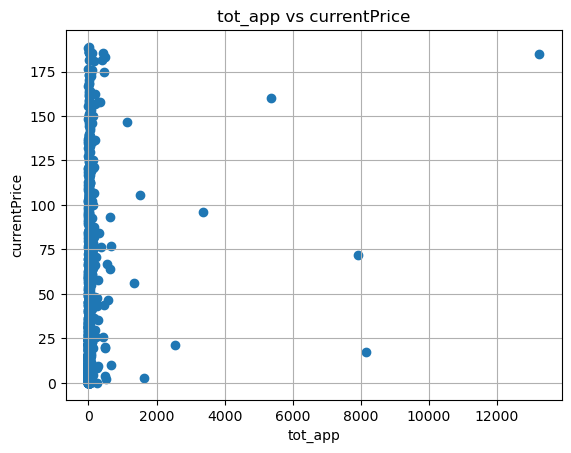

targetHighPrice


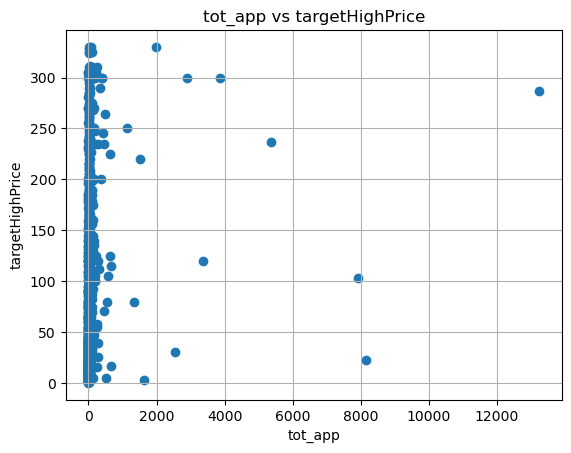

targetLowPrice


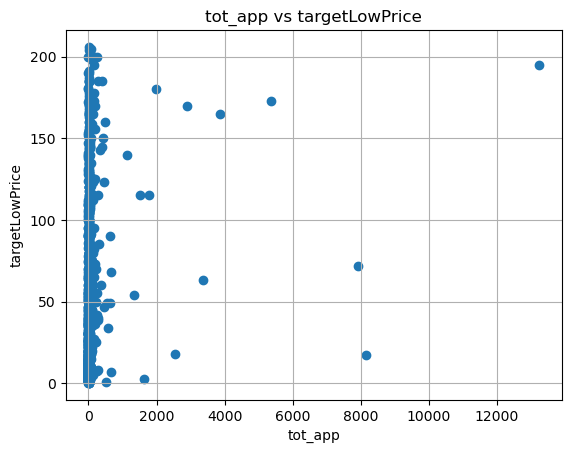

targetMeanPrice


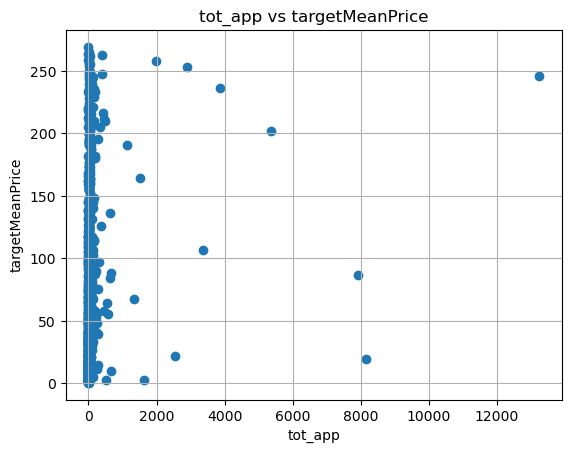

targetMedianPrice


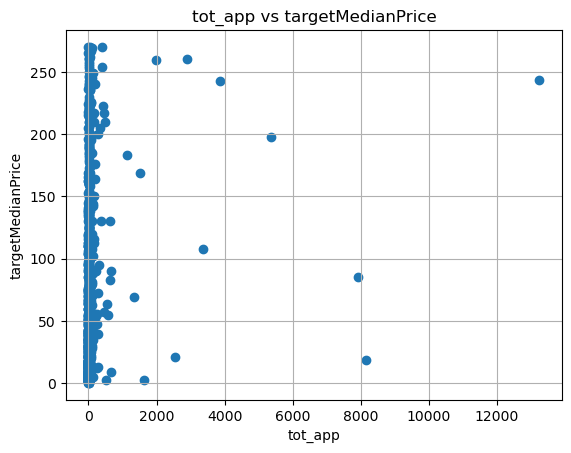

recommendationMean


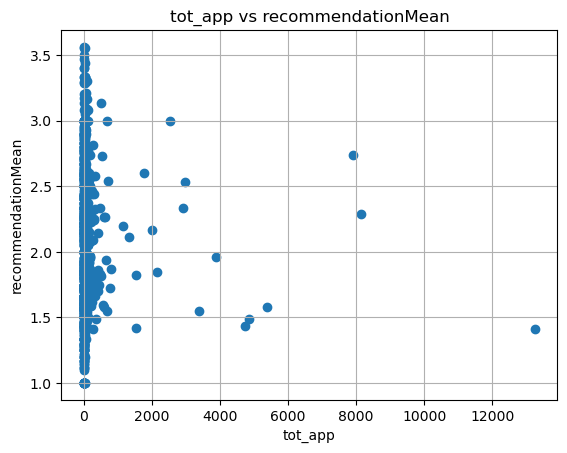

numberOfAnalystOpinions


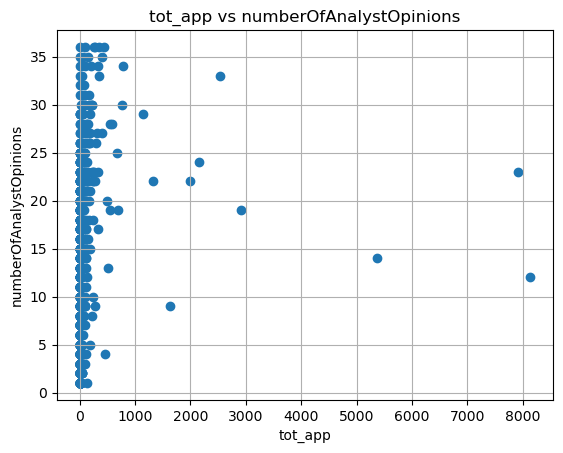

totalCash


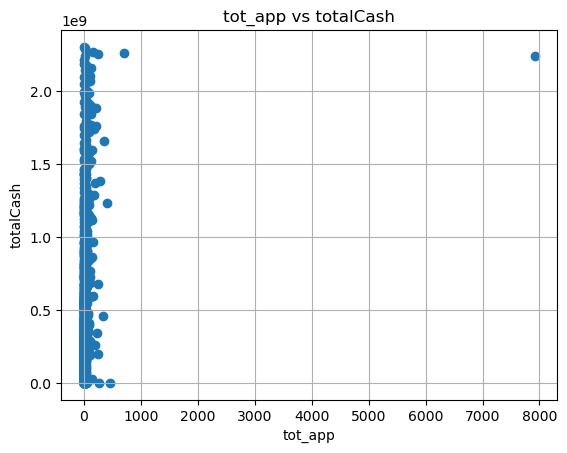

totalCashPerShare


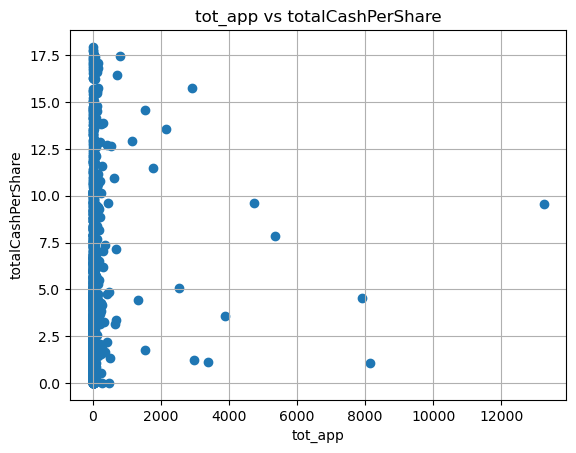

ebitda


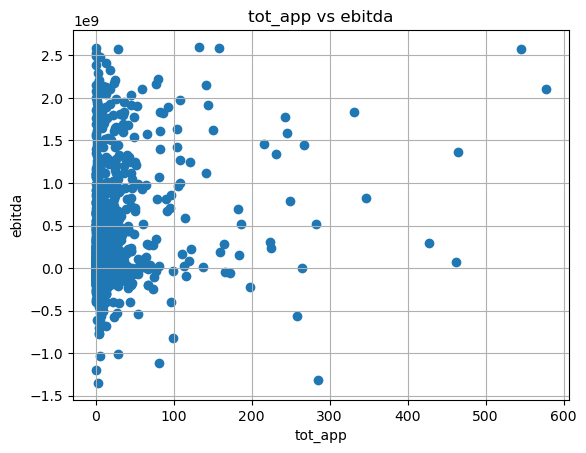

totalDebt


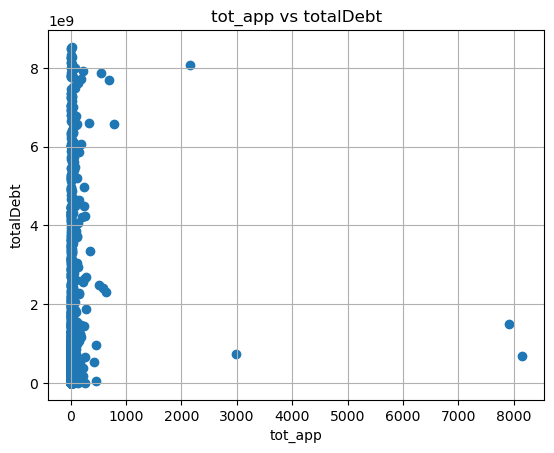

quickRatio


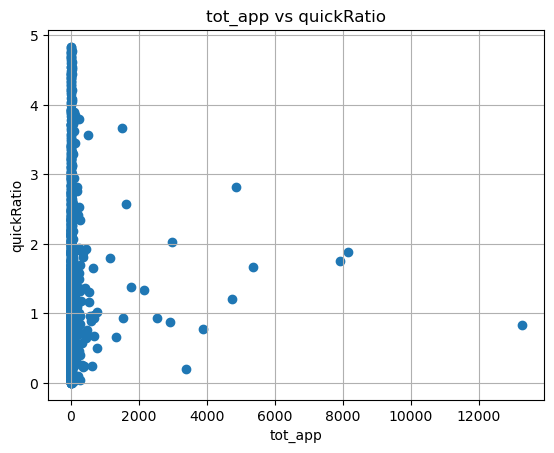

currentRatio


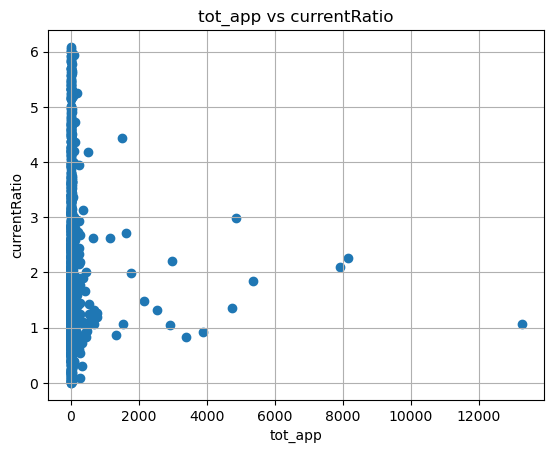

totalRevenue


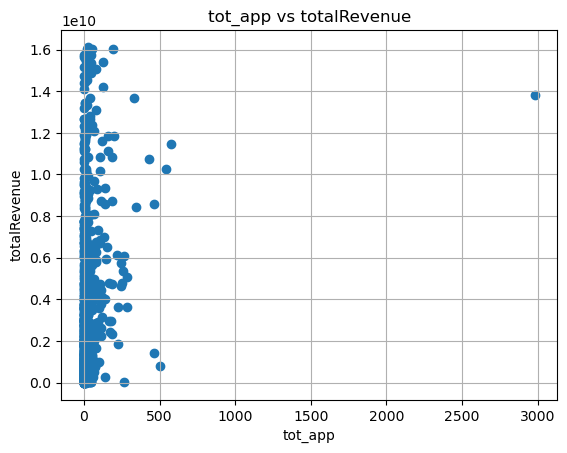

debtToEquity


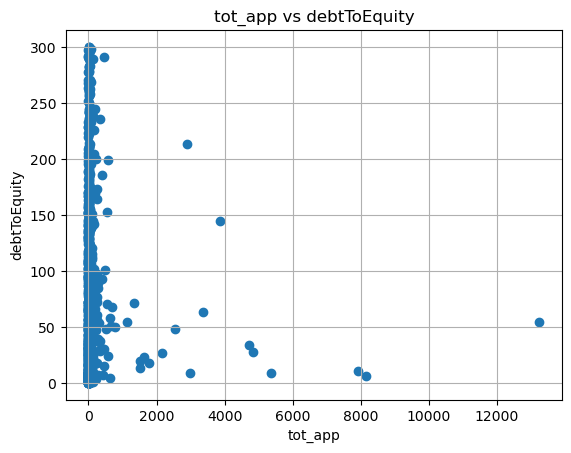

revenuePerShare


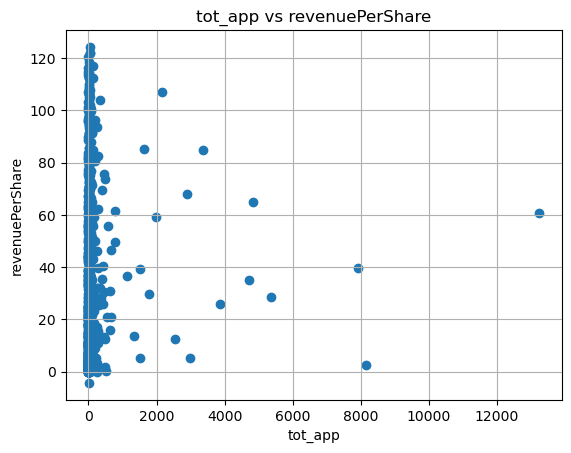

returnOnAssets


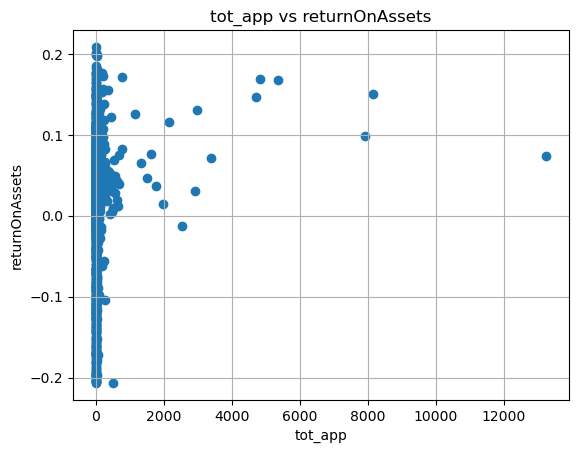

returnOnEquity


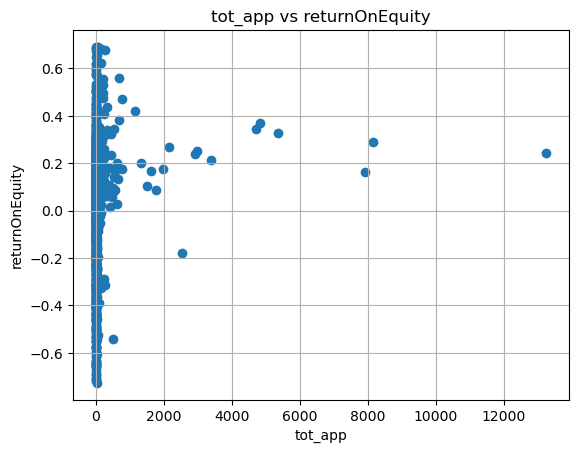

grossProfits


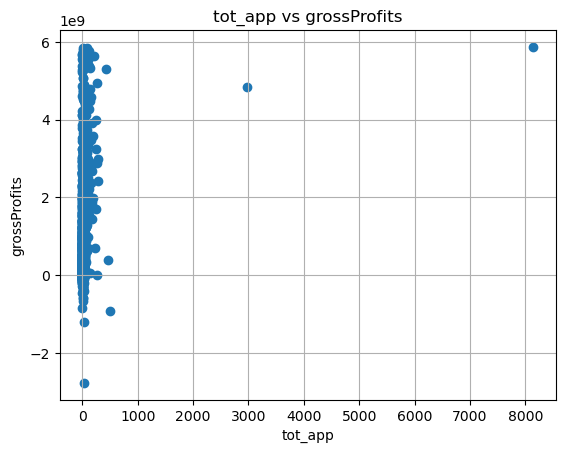

freeCashflow


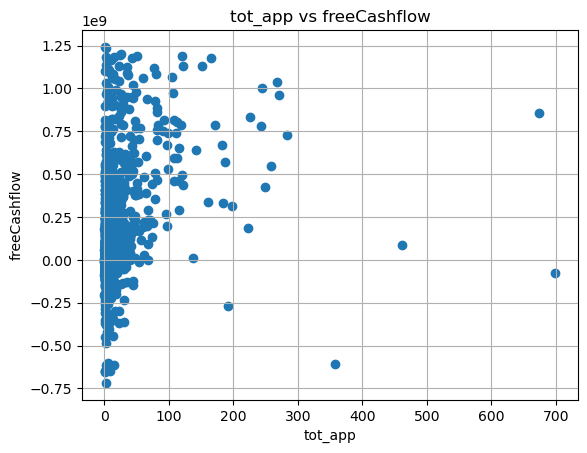

operatingCashflow


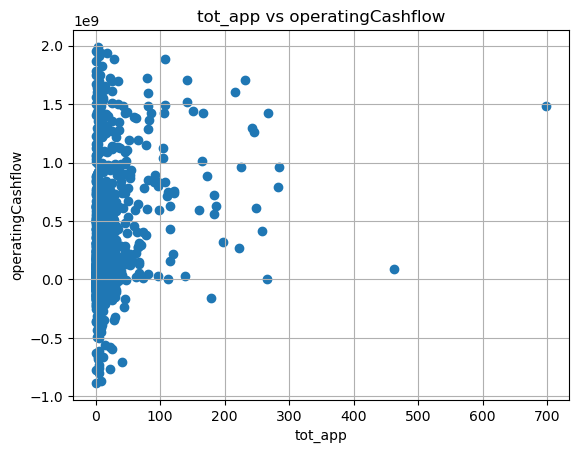

earningsGrowth


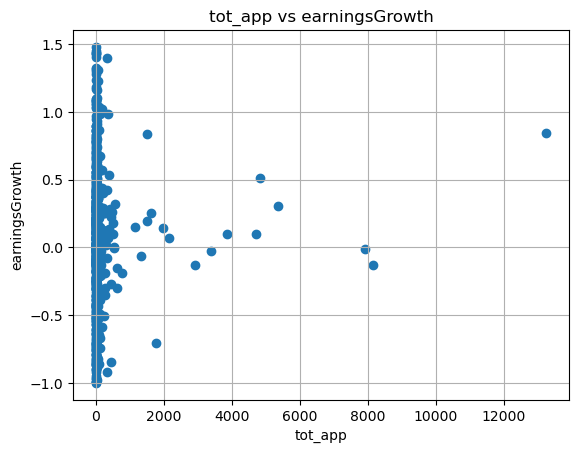

revenueGrowth


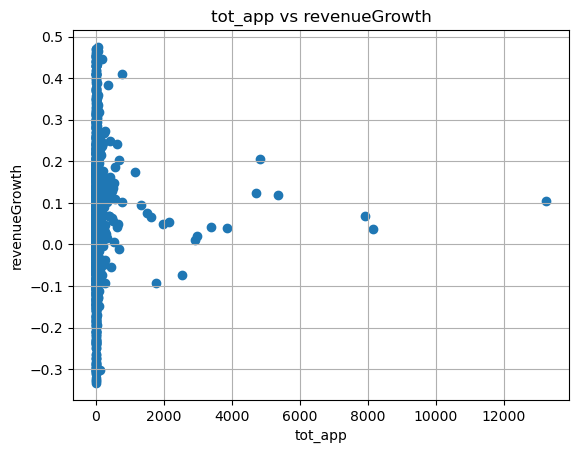

grossMargins


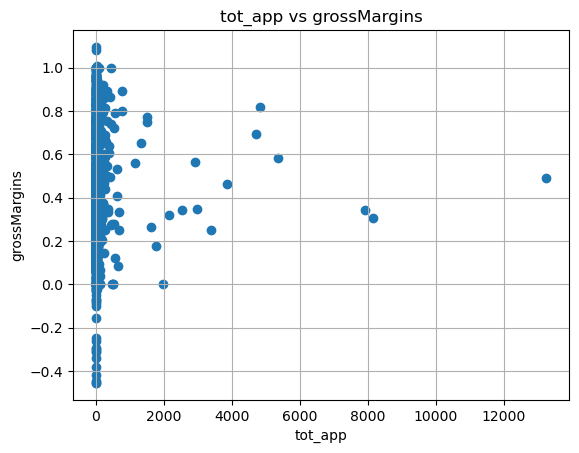

ebitdaMargins


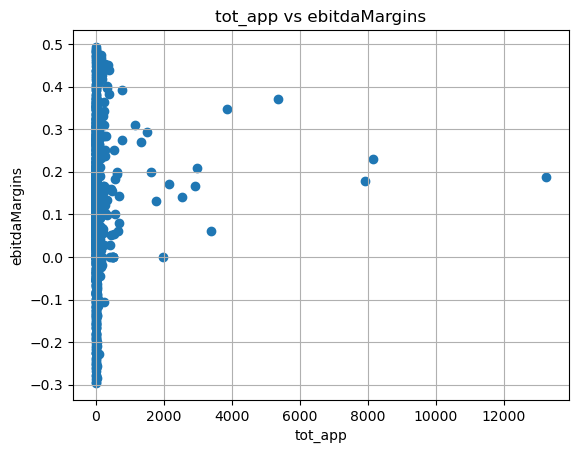

operatingMargins


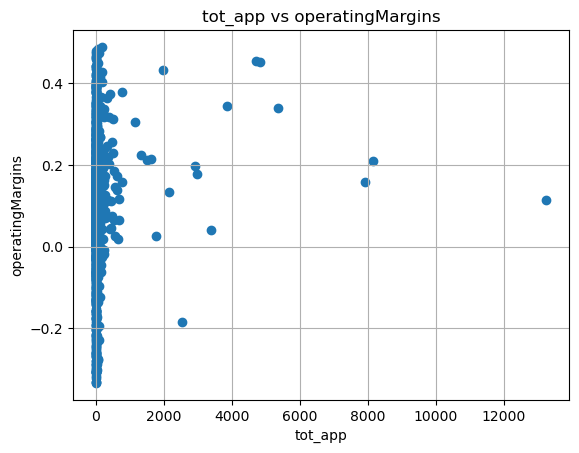

regularMarketTime


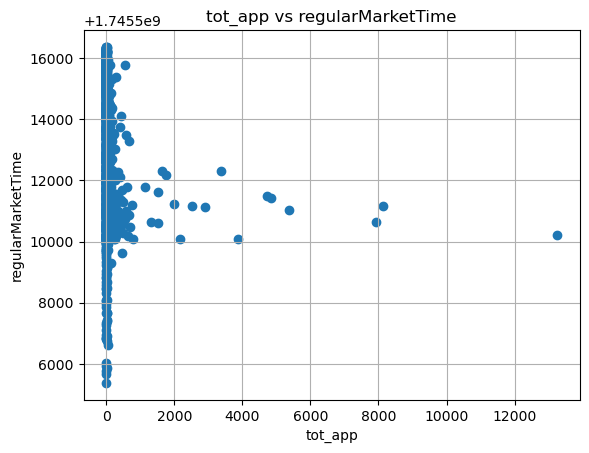

regularMarketChangePercent


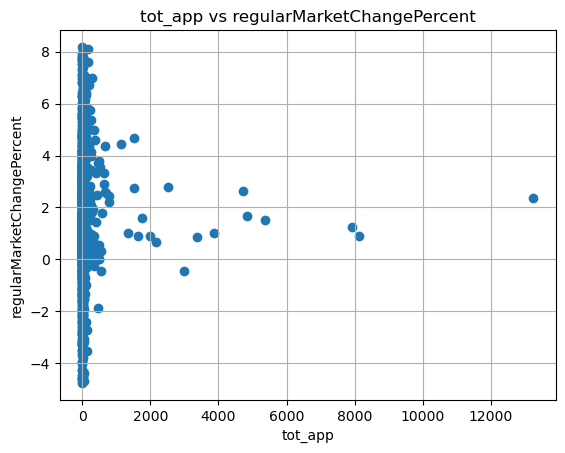

regularMarketPrice


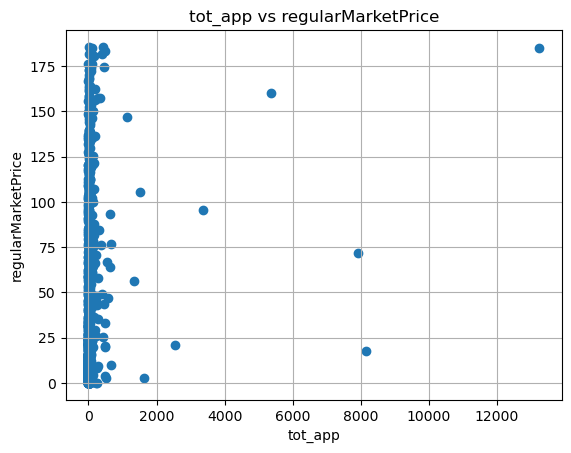

averageDailyVolume3Month


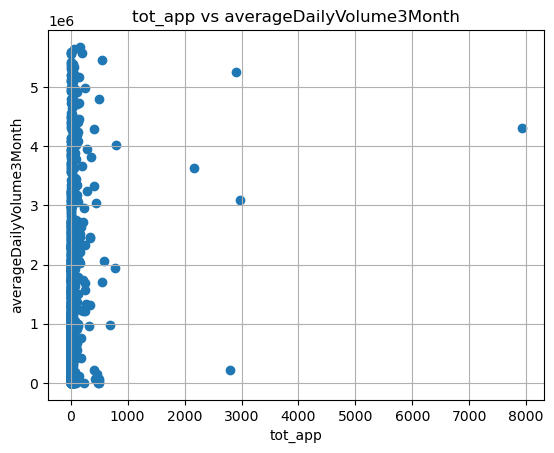

fiftyTwoWeekLowChange


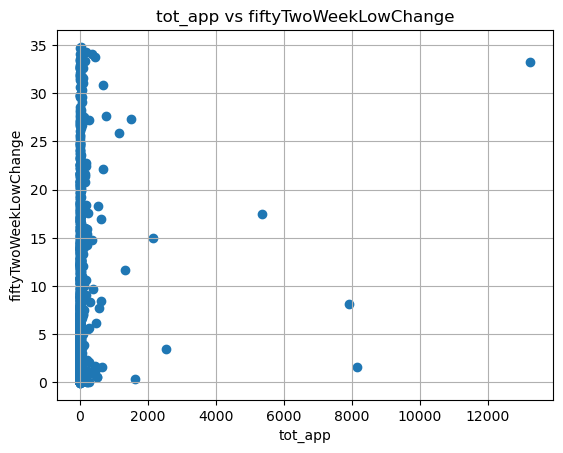

fiftyTwoWeekLowChangePercent


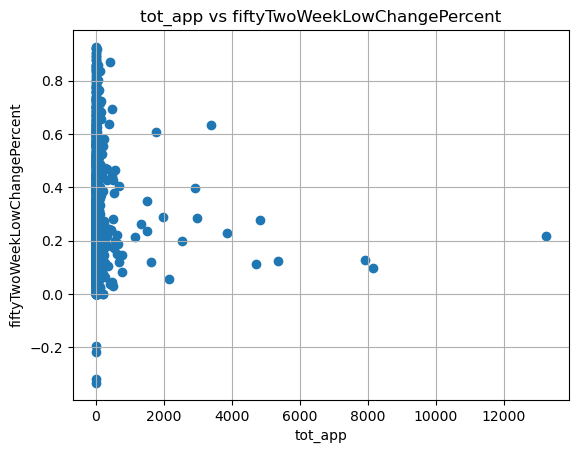

fiftyTwoWeekHighChange


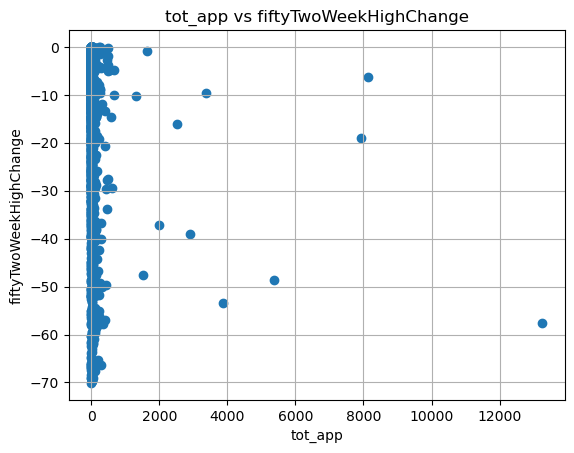

fiftyTwoWeekHighChangePercent


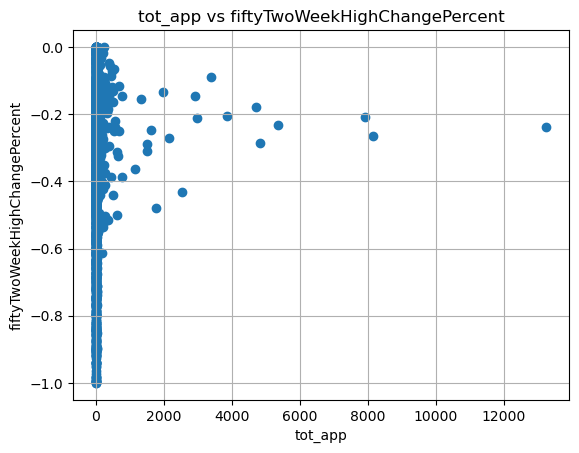

fiftyTwoWeekChangePercent


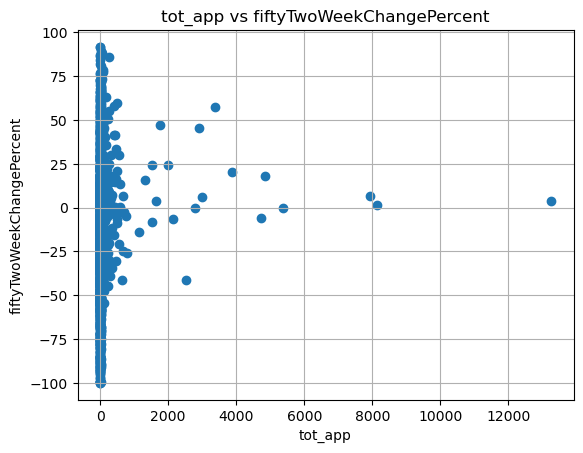

dividendDate


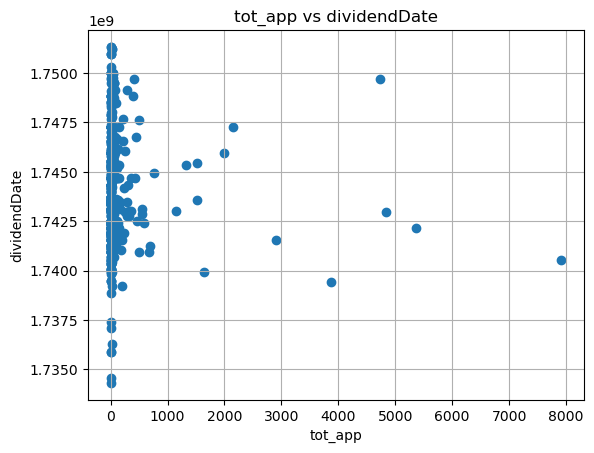

earningsTimestamp


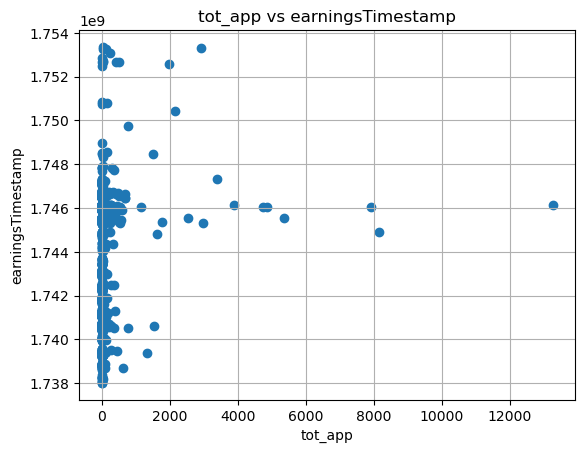

earningsTimestampStart


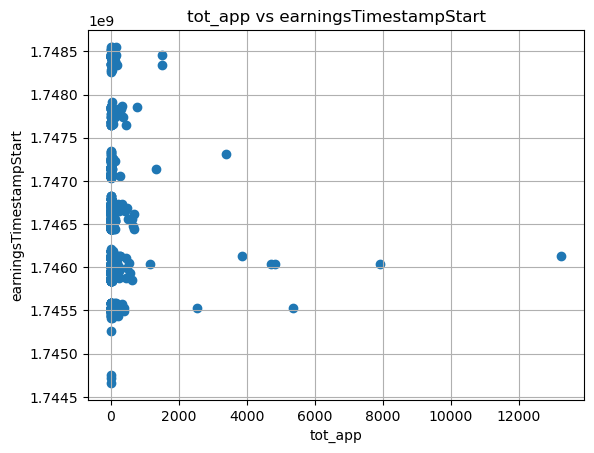

earningsTimestampEnd


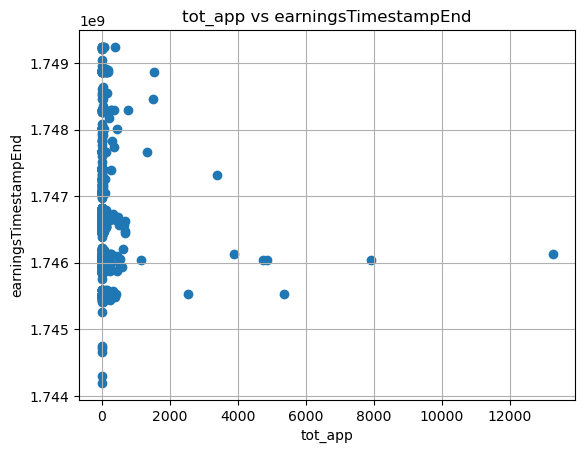

earningsCallTimestampStart


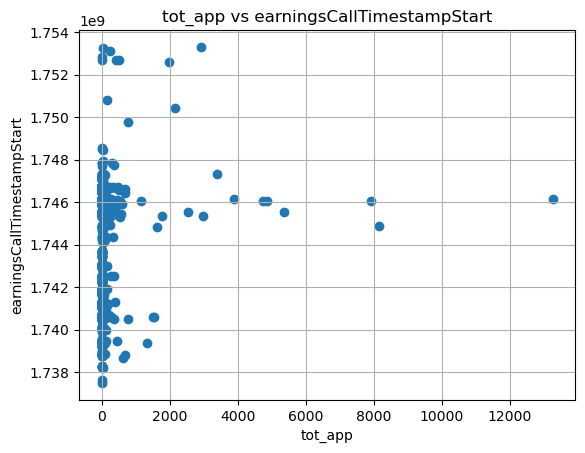

earningsCallTimestampEnd


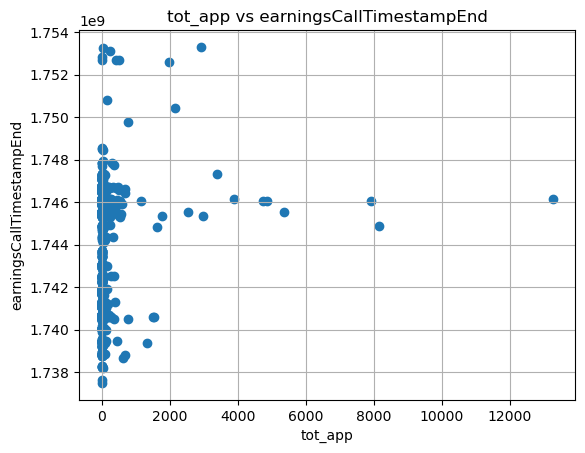

epsTrailingTwelveMonths


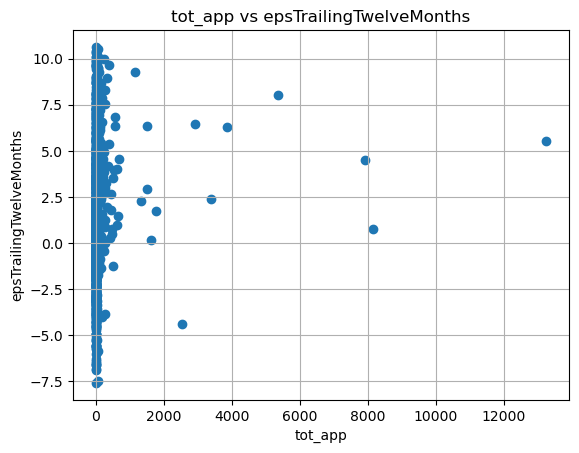

epsForward


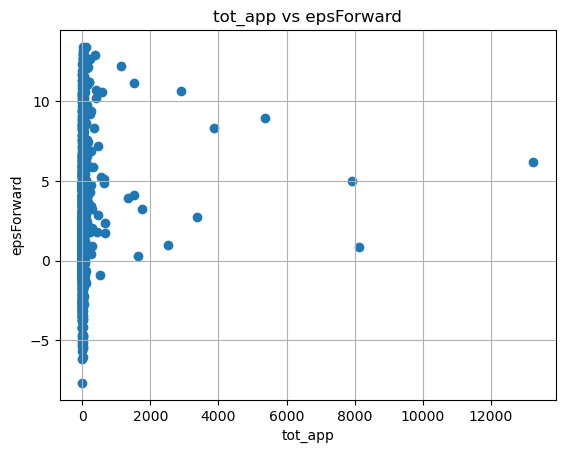

epsCurrentYear


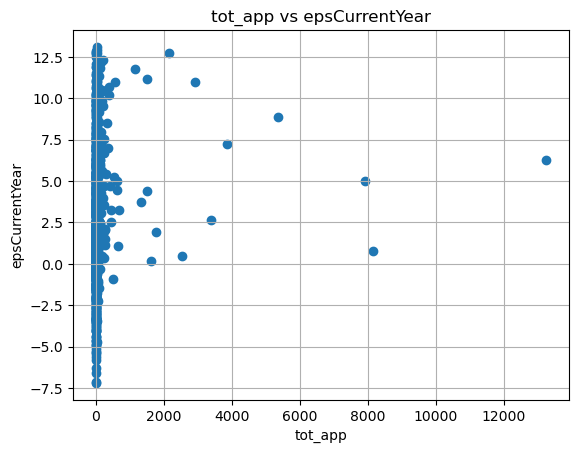

priceEpsCurrentYear


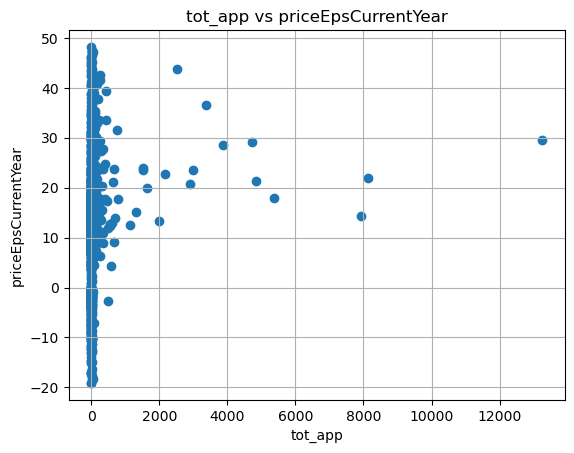

fiftyDayAverageChange


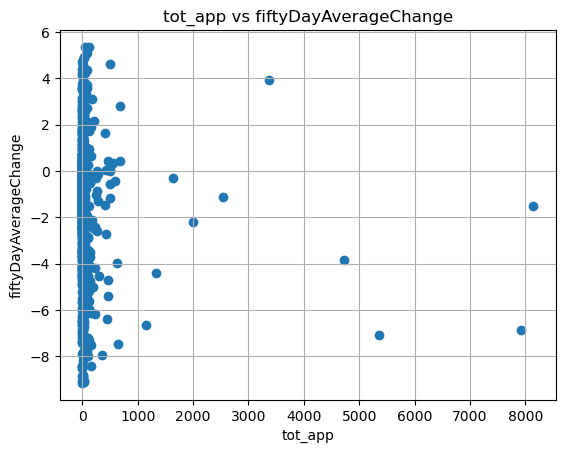

fiftyDayAverageChangePercent


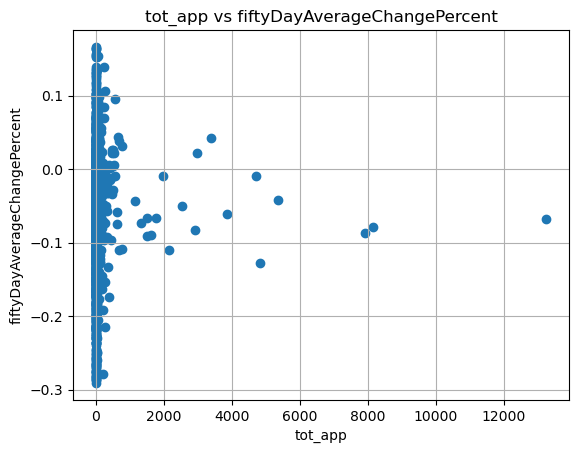

twoHundredDayAverageChange


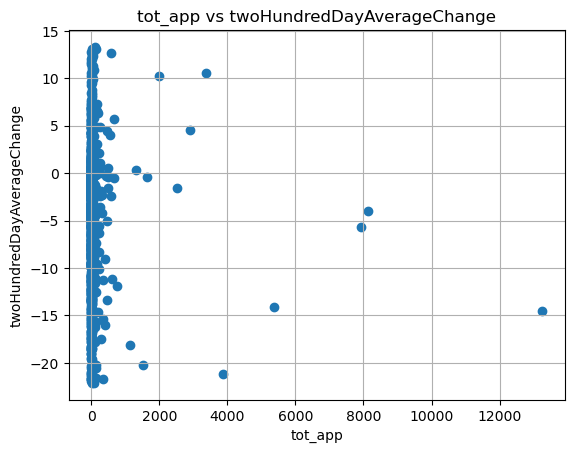

twoHundredDayAverageChangePercent


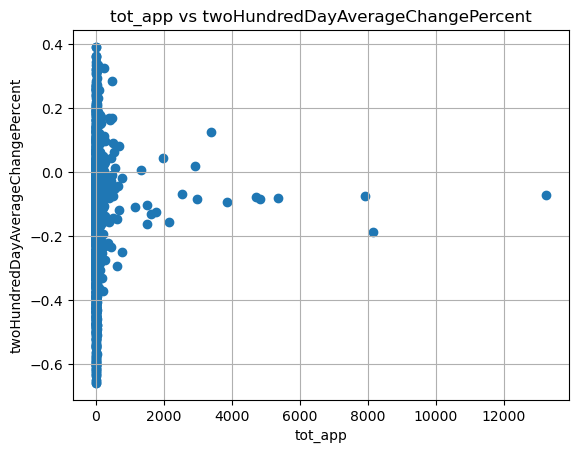

firstTradeDateMilliseconds


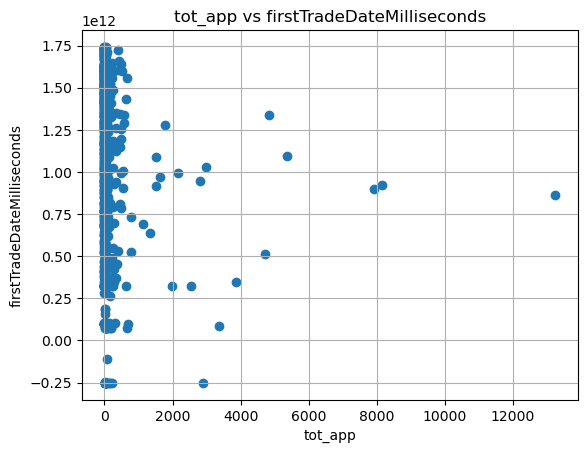

regularMarketChange


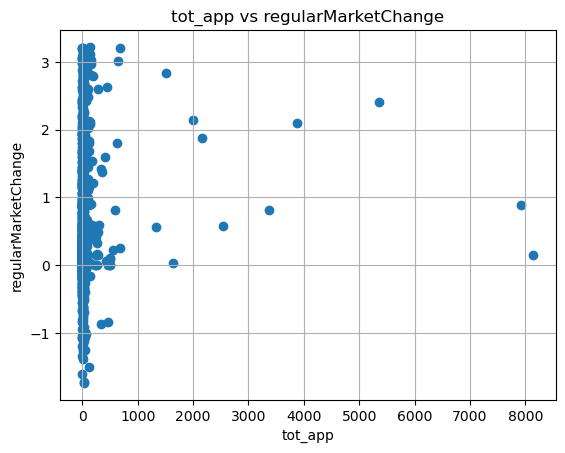

trailingPegRatio


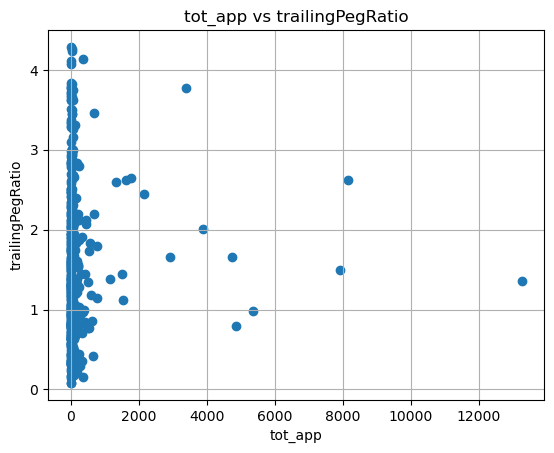

totalAssets


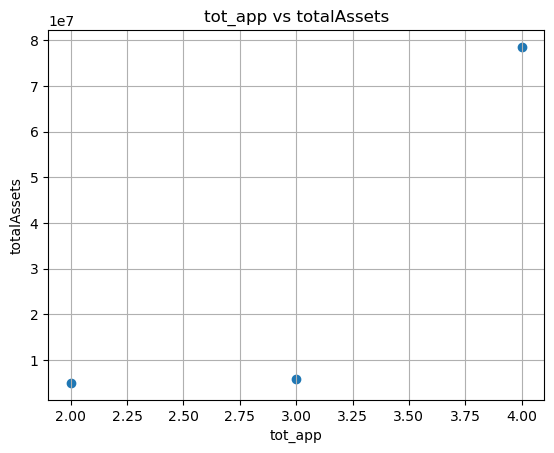

Fiscal Year


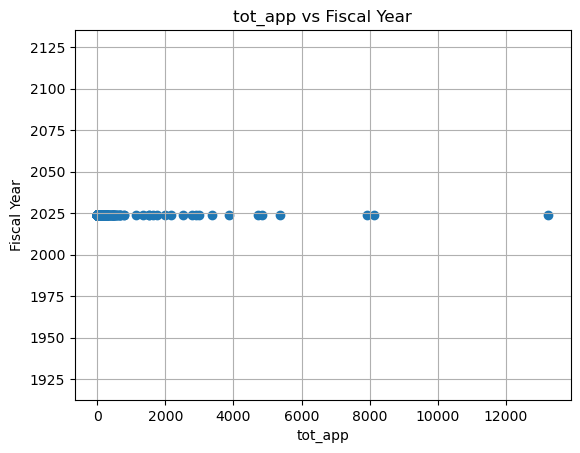

Tax ID


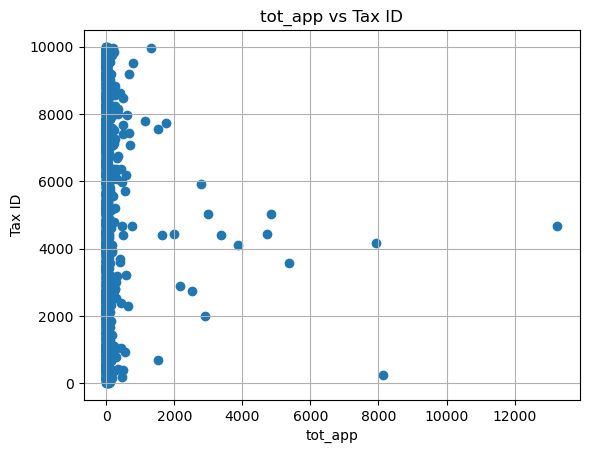

Petitioner Zip Code


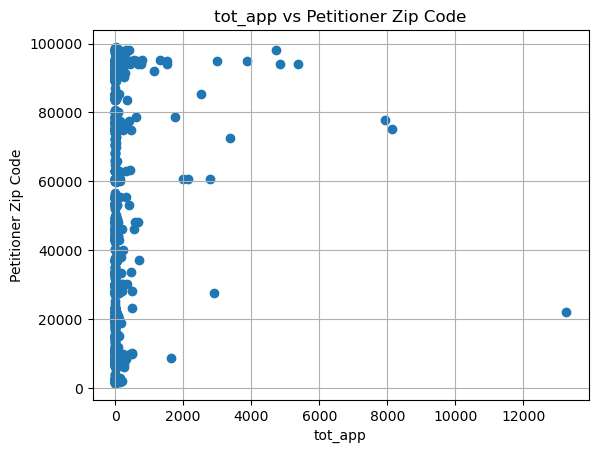

Initial Approval


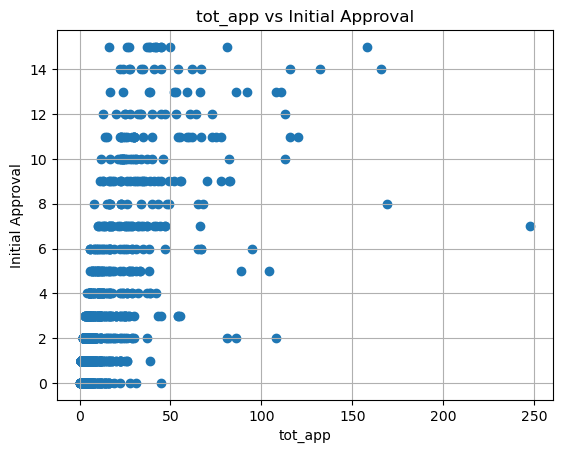

Continuing Approval


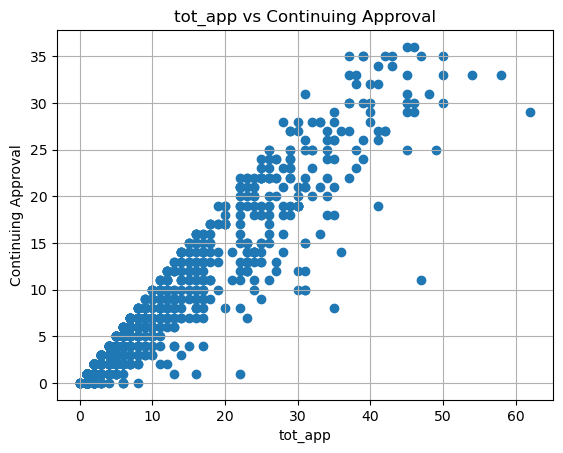

In [39]:
target_col = 'tot_app'
for col in visa_and_info_df.columns:
        if col != target_col and pd.api.types.is_numeric_dtype(visa_and_info_df[col]):
            print(col)
            data = remove_outliers_iqr(visa_and_info_df, col)
            plt.figure()
            plt.scatter(data[target_col], data[col])
            plt.xlabel(target_col)
            plt.ylabel(col)
            plt.title(f'{target_col} vs {col}')
            plt.grid(True)
            plt.show()

In [38]:
remove_outliers_iqr(visa_and_info_df, 'currentRatio')
#visa_and_info_df['currentRatio'].quantile(0.25)

Unnamed: 0                         address1         city state  \
0             A     5301 Stevens Creek Boulevard  Santa Clara    CA   
1            AA              201 Isabella Street   Pittsburgh    PA   
2           AAL                  1 Skyview Drive   Fort Worth    TX   
3          AAMI             200 Clarendon Street       Boston    MA   
4          AAOI      13139 Jess Pirtle Boulevard   Sugar Land    TX   
...         ...                              ...          ...   ...   
1571        WKC             9800 N.W 41st Street        Miami    FL   
1572         WS  100 West Old Wilson Bridge Road     Columbus    OH   
1573         WT             250 West 34th Street     New York    NY   
1574       WTRG          762 W. Lancaster Avenue    Bryn Mawr    PA   
1576       ZVRA       1180 Celebration Boulevard  Celebration    FL   

             zip        country           phone           fax  \
0          95051  United States    800 227 9770  866 497 1134   
1     15212-5858  United States    412 315 2900           NaN   
2          76155  United States    682 278 9000           NaN   
3          02116  United States    617-369-7300           NaN   
4          77478  United States  (281) 295-1800           NaN   
...          ...            ...             ...           ...   
1571       33178  United States    305 428 8000  305 392 5621   
1572       43085  United States    614 840 3462           NaN   
1573       10119  United States    212-801-2080           NaN   
1574  19010-3489  United States    610 527 8000           NaN   
1576       34747  United States    321 939 3416           NaN   

                               website                        industry  ...  \
0              https://www.agilent.com          Diagnostics & Research  ...   
1                https://www.alcoa.com                        Aluminum  ...   
2                   https://www.aa.com                        Airlines  ...   
3                 https://www.bsig.com                Asset Management  ...   
4               https://www.ao-inc.com         Communication Equipment  ...   
...                                ...                             ...  ...   
1571      https://www.world-kinect.com  Oil & Gas Refining & Marketing  ...   
1572  https://www.worthingtonsteel.com                           Steel  ...   
1573        https://www.wisdomtree.com                Asset Management  ...   
1574          https://www.essential.co     Utilities - Regulated Water  ...   
1576                 https://zevra.com                   Biotechnology  ...   

                     employer Tax ID                   Industry (NAICS) Code  \
0                     AGILENT   8772                   31-33 - Manufacturing   
1                       ALCOA   9115                   31-33 - Manufacturing   
2           AMERICAN AIRLINES   2798  48-49 - Transportation and Warehousing   
3               ACADIAN ASSET   9221              52 - Finance and Insurance   
4     APPLIED OPTOELECTRONICS   3927                   31-33 - Manufacturing   
...                       ...    ...                                     ...   
1571             WORLD KINECT   9427                    42 - Wholesale Trade   
1572        WORTHINGTON STEEL   5233                   31-33 - Manufacturing   
1573               WISDOMTREE   7784              52 - Finance and Insurance   
1574      ESSENTIAL UTILITIES   2594                          22 - Utilities   
1576       ZEVRA THERAPEUTICS   4398                   31-33 - Manufacturing   

     Petitioner City  Petitioner State Petitioner Zip Code  Initial Approval  \
0        SANTA CLARA                CA               95052                11   
1         PITTSBURGH                PA               15212                 1   
2         FORT WORTH                TX               76155                43   
3             BOSTON                MA                2110                 4   
4         SUGAR LAND                TX               77478   